# Please install the yellowbrick and keras packages first

In [ ]:
pip install yellowbrick

In [ ]:
pip install keras

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
sns.set_palette('husl')

from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler, Normalizer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, MissingIndicator
import sklearn.metrics as metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from math import isclose
from copy import copy

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, silhouette_visualizer
from yellowbrick.cluster.icdm import InterclusterDistance
from yellowbrick.datasets import load_nfl

In [2]:
# %logstop
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, FloatSlider, fixed

# Question One

In [3]:
# Load Training Data From Disc

data = pd.read_csv("water.csv", header=None)

- Here, we'll take a brief look at the data for the purpose of exploratory analysis and overview data.

In [4]:
data.head()

0     1     2     3     4     5     6     7     8     9     ...  2241  \
0  2.07  0.44  1.47  2.10  0.35  1.44  1.98  0.46  1.42  2.08  ...  1.33   
1  1.64  2.02  1.10  1.67  1.95  1.15  1.70  2.05  1.02  1.96  ...  1.30   
2  1.89  0.67  1.62  1.80  0.68  1.59  1.91  0.58  1.66  0.12  ...  1.35   
3  1.64  2.02  1.10  1.67  1.95  1.16  1.71  2.05  1.03  1.95  ...  1.29   
4  1.85  0.20  1.54  1.84  0.25  1.62  1.84  0.26  1.46  2.02  ...  1.19   

   2242  2243  2244  2245  2246  2247  2248  2249  2250  
0  1.30  1.38  1.39  1.25  1.31  1.26  1.35  1.34     1  
1  1.25  1.97  1.40  1.25  1.95  1.27  1.17  2.03     0  
2  1.15  1.51  1.41  1.11  1.44  1.29  1.22  1.46     1  
3  1.25  1.97  1.39  1.25  1.95  1.27  1.18  2.03     0  
4  1.41  1.81  1.23  1.32  1.78  1.21  1.43  1.91     1  

[5 rows x 2251 columns]

In [5]:
data.tail()

0     1     2     3     4     5     6     7     8     9     ...  2241  \
996   1.65  2.02  1.10  1.68  1.95  1.17  1.72  2.04  1.03  1.95  ...  1.30   
997   1.64  2.01  1.11  1.67  1.94  1.16  1.71  2.03  1.04  1.96  ...  1.30   
998   1.65  2.02  1.11  1.68  1.95  1.17  1.72  2.04  1.04  1.95  ...  1.29   
999   1.65  2.03  1.10  1.68  1.95  1.16  1.71  2.05  1.03  1.96  ...  1.29   
1000  1.85  0.61  1.41  1.75  0.59  1.44  1.91  0.64  1.49  0.18  ...  1.00   

      2242  2243  2244  2245  2246  2247  2248  2249  2250  
996   1.26  1.97  1.40  1.25  1.96  1.27  1.18  2.03     0  
997   1.25  1.96  1.40  1.25  1.95  1.27  1.18  2.02     0  
998   1.26  1.98  1.39  1.26  1.96  1.27  1.18  2.04     0  
999   1.26  1.97  1.39  1.25  1.95  1.26  1.19  2.03     0  
1000  1.13  1.89  1.01  1.22  1.93  1.09  1.08  1.90     1  

[5 rows x 2251 columns]

## Are there any Missing Data?

- An important question to ask is how many observations, if any, have missing data and what proportion of entire set this represents

In [6]:
print("Proportion of missing values")
print(data.isnull().sum().sum()*100/len(data))

print("Proportion of missing values")
print(data.isna().sum().sum()*100/len(data))

Proportion of missing values
0.0
Proportion of missing values
0.0


- The data has no missing values

## Slice Out The Flag Column

- Since the 2251st column are the flag labels, they will be dropped from the dataframe and set as $Flags$ 

In [7]:
flags = data.iloc[:,2250]

In [8]:
data = data.drop(columns=[2250])

## Feature Engineering

#### Obtain the Feature Space

- The new DataFrame has 2250 features for 1001 snapshots

- The objective is to reshape the feature space to a $750$ $X$ $3$ equavalent to a dimension corresposing to $Atoms$ $X$ $Coordinates$

In [9]:
# Convert the dataframe into an array to allow easy reshaping

X = data.to_numpy()

In [10]:
# reshape feature vectors into 750 X 3 dimensions

X = X.reshape((1001, 750, 3))

- In the new configuration, the shape $1001$ $X$ $750$ $X$ $3$ is equivalent to $Snapshots$ $X$ $Atoms$ $X$ $Coordinates$

- Now, we'll subtract the first coordinates from all coordinates in order to create a reference coordinate.

- This reference cooridinate will have values $0$, $0$, $0$

In [11]:
# Initialize new feature matrix as 3d matrix of shape (1001, 750, 3), for feature transformation

X_new = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
y_new = np.zeros((X.shape[0], X.shape[1], 1))

# loop through all 1001 snapshots (i.e slices in the 3d matrix)
for i in range(0, len(X)):
    # Subtract coordinates in row 0 from coordinates in all other rows
    X_new[i, :, :] = X[i][:, :] - X[i][0, :]
    y_new[i, :, 0] = flags[i]

- now, we reshape the feature vectors into a vector or dimensions 2250 for each of the 1001 snapshots

In [12]:
# Reshape back into (1001, 2250) matrix

X = X_new.reshape((1001, 2250))

#### Data Transformation

- For training pruposes, we require some kind of transformation that will covert the feature space into a more relevant feature space for the clustering algorithm.

- To make this transformation, we consider the irreducible representation of the symmetry group of the raw data. 

- Examples of such symmetry groups for the vector coordinates being delt with here are

$$Rotation$$

$$Translation$$

- These operations when performed on the data sets should maintain invariance of the problem.

- However, we have performed such transformation in prior steps by subtracting the first vector from all other vectors in the snapshot in the $750$ $X$ $3$ representation of the feature vectors. 

- This procedure only creates a reference cooridnate ($0$, $0$, $0$) that doesn't change necessarily the physics. It generally implies that we can give only the coordinates of one of the atoms relative to the other, which is equivalent to the vector difference between the coordinates of the atoms.

- In summary, what we have done here highlights the translational invariance of the molecule since the molecule looks the same no matter where in space it is located. 

- Coupled with the fact that each of the feature vectors in the $2250$ dimensional feature space are all $vector$ $coordinates$, which have the physical measurements units, no further transformations need to be done. 

- This is further validated by the fact that the inherent distance measures$-$used to form clusters$-$use $vector$ $coordinates$ in the $Euclidean$ $space$. Since the the data already has such a representation, there's no pressing need for further transformation. 

#### Dimensionality Reduction 

- The feature space has an extremely high dimensionality of 2250 feature vectors. One can therefore intuitively note that obtaining distance measures at such high dimensions is notoriously difficult.  

- More so, the distance between the data points and the origin of the coordinate system grows as a square root of the number of dimensions D, which will in turn lead to divergence of the the Euclidean distance metric employed by most clustering algorithms of interest.

- Since all of these feature vectors may not be necessary for explaining the overall variance (underlying structure)for individual snapshots, it is imporotant to investigate if a reduced set of feature vectors can capture ~$100$% of the overall data structure.  

- This will be done using $Principal$ $Component$ $Analysis$ because the algorithm inherently supports unserpeprvised learning , which is of particular interest in this question. 

- We will call the $Decomposition.PCA()$ method and investe the $cummulative$ $explained$ $variance$ $ratio$ as a function of number of components. 

- Since this automatically sorts the components in order of increasing variance, the first $n$$-$$components$ that results in ~$100$% of the $cummulative$ $explained$ $variance$ $ratio$ will be reserved as the set of new feature vectors

Text(0, 0.5, 'cumulative explained variance')

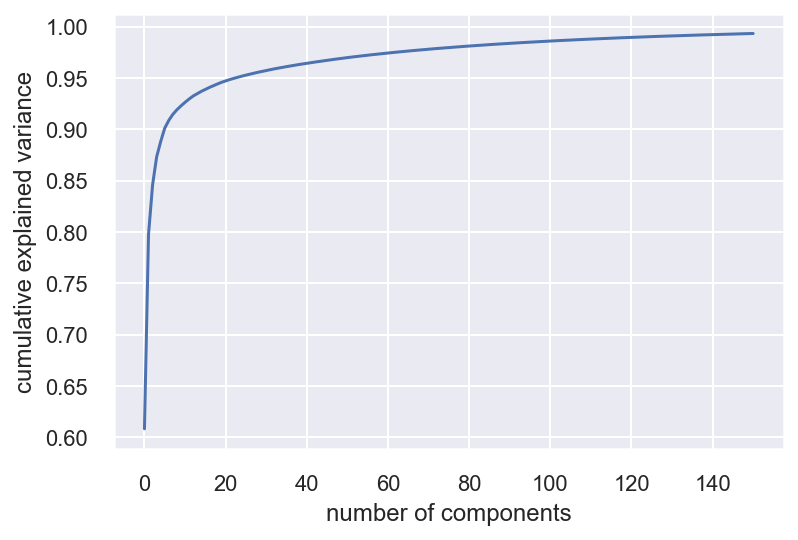

In [13]:
#call PCA method and fit
pca = PCA().fit(X)

# plot cummulative variance (eigenvalues) explained by the first 150 eigenvectors

plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:151])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

##### The curve above gives the cumulative explained variance, which measures how well PCA preserves the content of the data

- This curve quantifies how much of the total, 2250-dimensional variance is contained within the first $N$ $components$. For example, we see that with the snapshoots, the first 10 components contain approximately ~$93$% of the variance, while you need around 150 components to describe close to $100$% of the variance.

- Therfore, we see that a 150-dimensional projection retains a lot of information (as measured by the explained variance) and that we’d need about 150 components to retain ~$100$% of the variance.

- $Why$ $Is$ $The$ $150$$-$$dim$ $vector$ $a$ $reasonable$ $size$ $for$ $the$ $new$ $feature$ $space$? Because the size of the reduced feature space is markedly smaller than the size of the raw feature space, while still achieving ~$100$% explained variance. 

#### Project Data Unto Lower (150-) Dimensional Space

In [14]:
# call PCA method and project raw data into new eigenbasis
pca = PCA(n_components=150)

X_projected = pca.fit_transform(X) 

#check new shape of reduced feature vectors
print(X_projected.shape)

(1001, 150)


## Clustering on Reduced Data

- Here we compare performance of 3 popular clustering algorithms on the data set;

$$Kmeans$$

$$AgglomerativeClustering$$

$$DBSCAN$$

#### KMeans Algorithm -- Centroid Based Clustering

- The $K$-$Means$ algorithm is tested because it is perhaps the simplest algorithm in the group of $Centroid$ $Based$ $Clustering$ algorithms

- A particular disavantage of the $Centroid$ $Based$ $Clustering$ algorithms is that they require the number of clusters to be specified a-priori which is hard to optimize due to inapplicability of cross-validation for clustering

- Here we will vizualize $Silhouette$ $Curves$ for a range of cluster numbers in combinations with the hyperparamters specifying methods for initialization, so as to obtain the optimal number of clusters and initialization method.

- The initialization methods considered are; 

    - " ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. "

    - " ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids "  source https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


Text(0.04, 0.5, 'Number of Clusters')

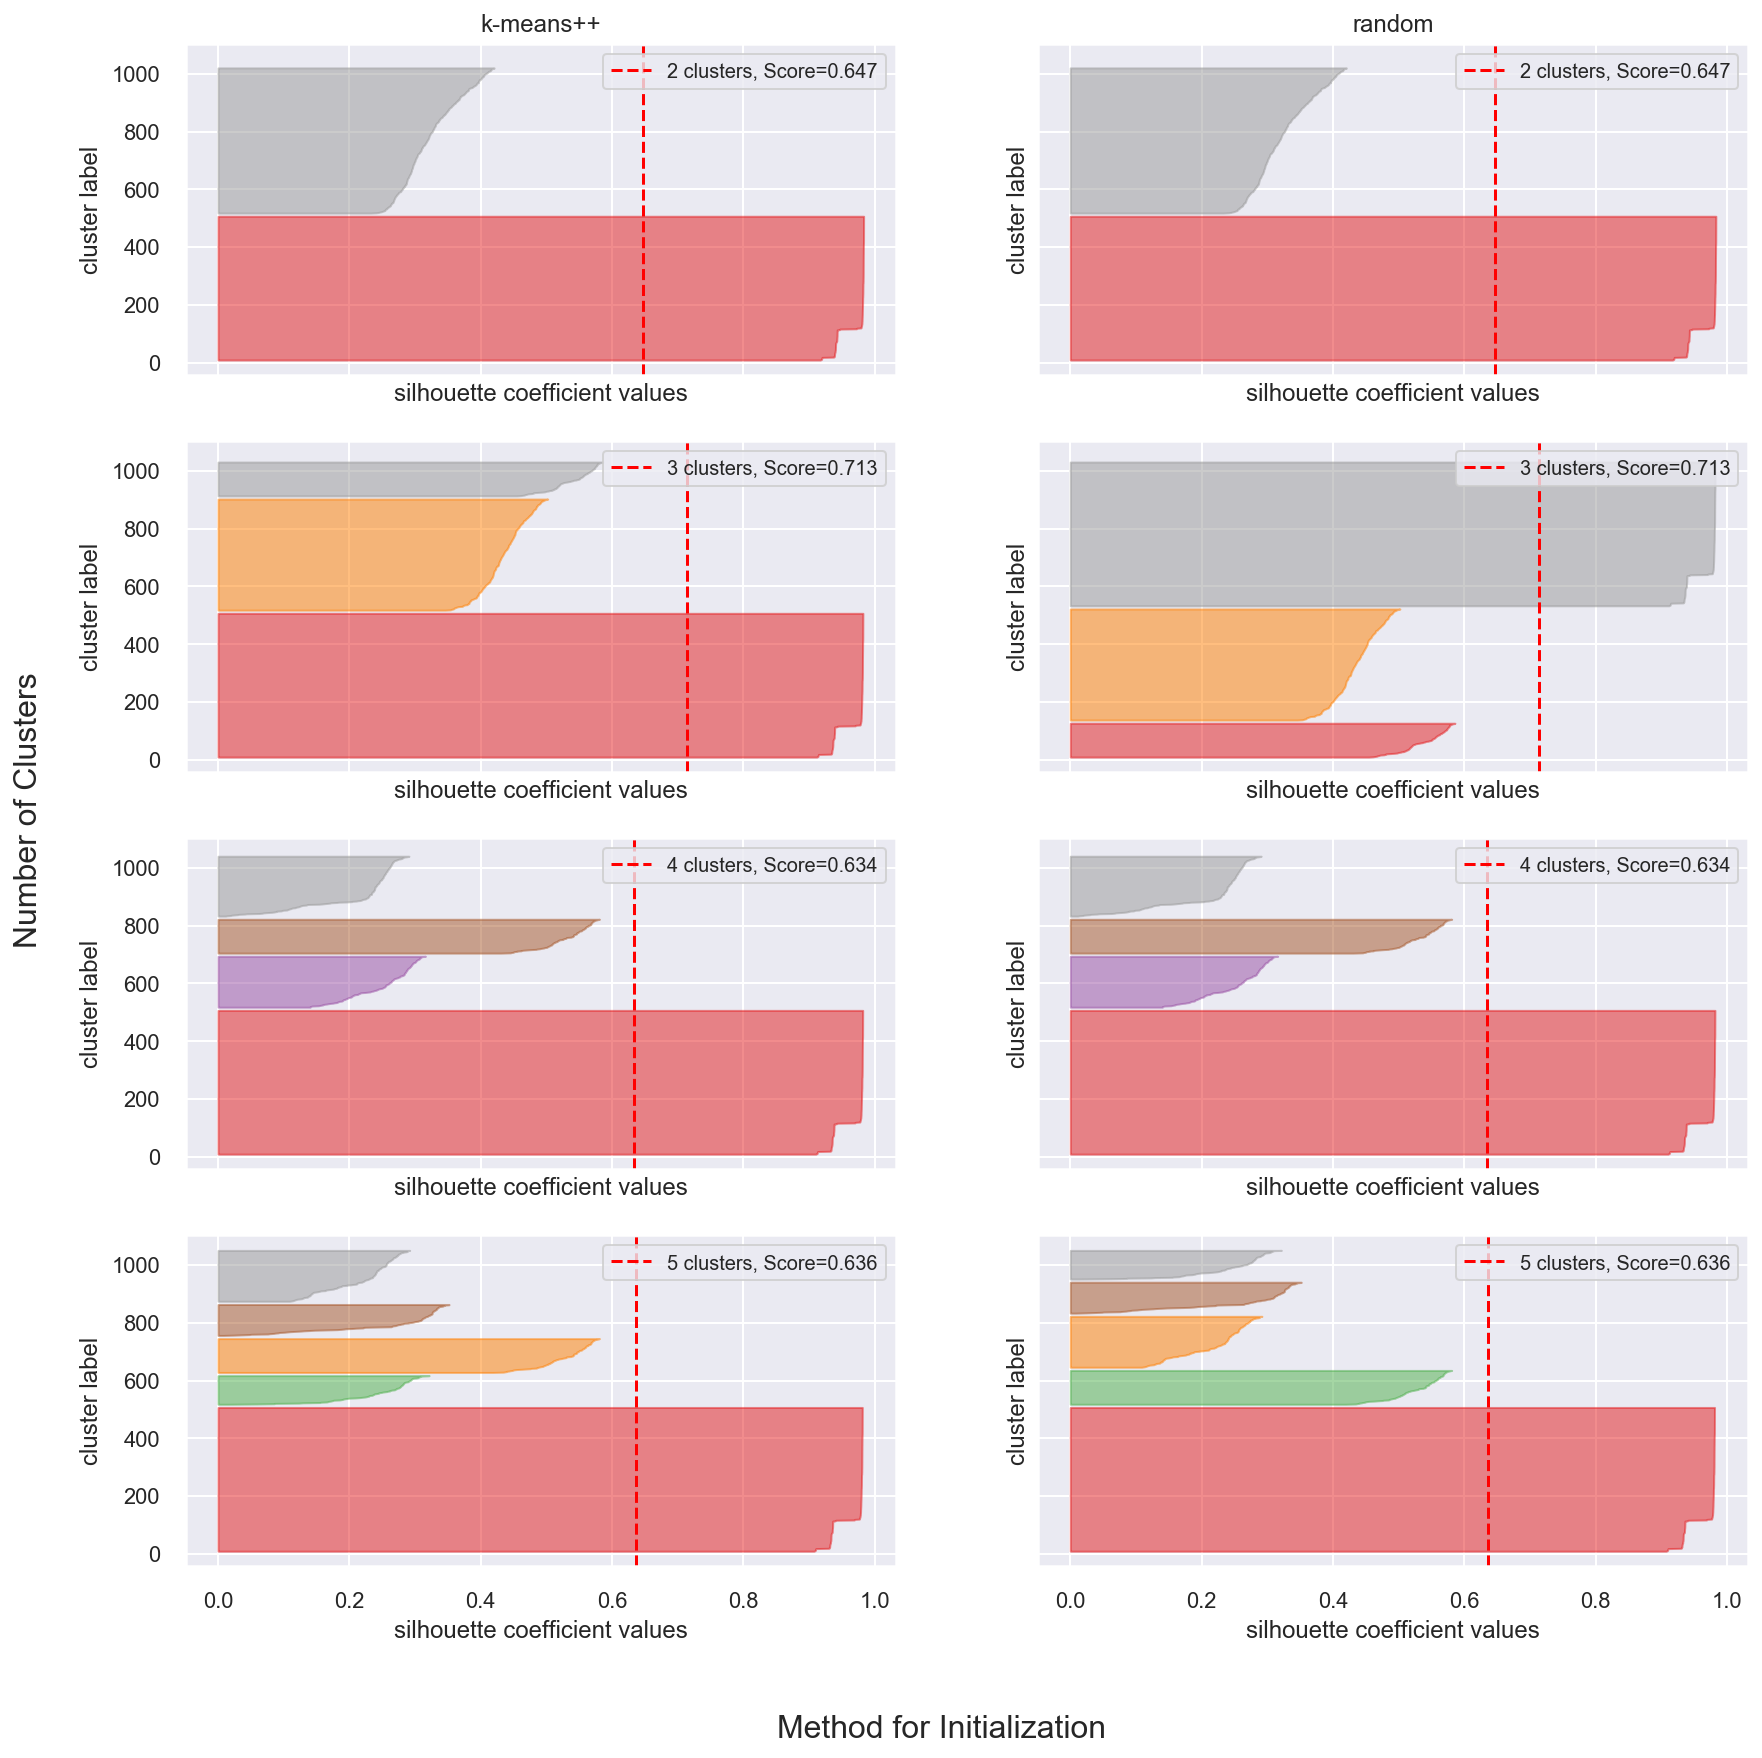

In [15]:
#initialize number of clusters as a list for looping
n_clusters = list(np.arange(2, 6))

#list for methods of initialization to be considered 
init_method = ["k-means++", "random"]

# dataframe for errors for init_method, n_cluster combinations
kmeans_error = pd.DataFrame(columns=["k-means++", "random"], index=n_clusters, dtype=float)

# save labels to 3d array for  init_method, n_cluster combinations
y_kmeans_pr = np.zeros((len(n_clusters), X_projected.shape[0], len(init_method)))

fig, axs = plt.subplots(nrows=len(n_clusters), ncols=len(init_method), figsize=(14, 14), sharex=True, sharey=True)

for n_idx, n in enumerate(n_clusters):
    for method_idx, method in enumerate(init_method):
        kmeans = KMeans(n_clusters=n, init=method)
        kmeans.fit(X_projected)
        y_kmeans = kmeans.predict(X_projected)
        y_kmeans_pr[n_idx, :, method_idx] = y_kmeans
        kmeans_error.loc[n, method] = kmeans.inertia_
        # Creating SilhouetteVisualizer and assigning it to an axis
        visualizer = SilhouetteVisualizer(kmeans, ax=axs[n_idx, method_idx], is_fitted='auto', legend=True)
        visualizer.fit(X_projected)
        # Setting subplot legends via axis
        axs[n_idx, method_idx].legend([f'{n} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                            loc="upper right", frameon=True, fontsize=10)
        # Setting subplot x and y labels
        axs[n_idx, method_idx].set(xlabel='silhouette coefficient values', ylabel='cluster label')

axs[0, 0].set_title("k-means++")
axs[0, 1].set_title("random")

fig.text(0.5, 0.04, 'Method for Initialization', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Number of Clusters', va='center', rotation='vertical',fontsize=16)

#### Comments

- Since silhouette coefficients near $+$$1$ indicate that the sample is far away from the neighboring clusters and a value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters, and negative values indicate that those samples might have been assigned to the wrong cluster, we can draw the following conlcusions from the $K$$-$$Means$ clustering algorthim;

    - That, at first glance, $n$_$clusters$ values of $2$, $3$, $4$, and $5$ do not yield acceptible clustering of the data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.
    
    - More so, the silhouette analysis doesn't yield significantly differing results for both initialization methods considered.
    
- A plausible reason for the failure of this algorithm could be it's lack of flexiblity. Since the feature space has a high demnsionality, it is possible that the clusters are noncircular, thus, such centroid-based clustering algorithm which can handle only clusters with spherical or ellipsoidal symmetry are likely to provide a very poor fit. 

- Although the clustering algorithm doesn't produce very good fit, it is seen from the plot that the number of clusters with the best score is $3$

#### Visualize K-Means Elbow

- In order to expand the the range of $n$_$clusters$ considered in the algorithm, we will plot the elbow (inertia) curves for a wide range of values. This will also help to consolidate the deductions from the silhouette analysis. 

- To aid direct comparison, the metric used in this plot is the $Calinski$-$Harabasz$ $Index$ which, the ratio of within to between cluster dispersion. The dispersion is defined as the sum of distances squared. 

- Higher scores of this index reflect dense, well separated clusters, which gives a reasonable standard concept of a cluster.

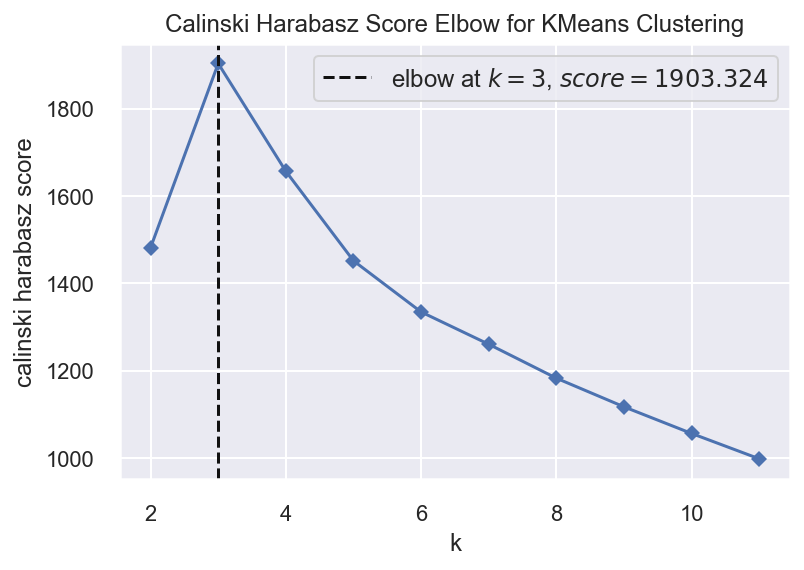

In [16]:
kmeans_model = KMeans()
n_clusters_range = (2, 12)
visualizer = KElbowVisualizer(kmeans_model, k=n_clusters_range, metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(X_projected)
visualizer.show()

#### Comments

- It is evident from the silhouette analysis and the elbow plot that the optimal number of clusters predicted by the  $K$$-$$Means$ clustering algorthim is $3$ since this results in the highest silhouette coefficient (nearest to +1) and $Calinski$-$Harabasz$ score, which by definition indicates highly dense clusters. 


- However, the analysis shows that n_clusters value of $3$ is still a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.

- Therefore, this model will be trained with $n$_$clusters$ = $3$ but other clustering algorithms will have to be tested to see if they produce better results/fits.

#### Fitted Model

- $K$-$means$ fittted with $n$_$clusters$ = $3$ and $init$_$method$ = $K$-$means++$

In [17]:
kmeans = KMeans(n_clusters=3, init="k-means++")
kmeans.fit(X_projected)
y_kmeans = kmeans.predict(X_projected)

#### Agglomerative Clustering -- Heirachical Clustering

- A reason for the poor performance of the $K$-$Means$ algorithm could be the lack of flexibility in cluster shape coupled with the curse of dimensionality that could lead to the divergence of the Euclidean Distance.

- Since $Heirachical$ $Clustering$ algorithms recursively merge pair of clusters that minimally increases a given linkage distance, it is possible that this resolves the sphere-like clustering therefore having fewer assumptions about the distribution of the data - the only requirement (which $K$-$Means$ also shares) is the distance metric calculated for each pair of clusters.. 

- Therefore, in order to have more control over the shape of cluster assignment, the Agglomerative Clustering algorithm is considered, since it doesnt restrict the cluster to be spherical.

- Here we will vizualize $Silhouette$ $Curves$ for a range of cluster numbers as well as combinations of the hyperparamters specifying the affinity, so as to obtain the optimal number of clusters and distance metric.

- The distance measures considered are; 

    - 'euclidean': Usual square distance between the two vectors (2 norm)."

    - 'manhattan':	Absolute distance between the two vectors (1 norm). 

#### Below is a collapsed cell function for plotting. Please run the cell first

In [18]:
# yellowbrick.cluster.silhouette
# Implements visualizers using the silhouette metric for cluster evaluation.
#
# Author:   Benjamin Bengfort
# Author:   Rebecca Bilbro
# Created:  Mon Mar 27 10:09:24 2017 -0400
#
# Copyright (C) 2017 The scikit-yb developers
# For license information, see LICENSE.txt
#
# ID: silhouette.py [57b563b] benjamin@bengfort.com $

"""
Implements visualizers that use the silhouette metric for cluster evaluation.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np
import matplotlib.ticker as ticker

from sklearn.metrics import silhouette_score, silhouette_samples

from yellowbrick.utils import check_fitted
from yellowbrick.style import resolve_colors
from yellowbrick.cluster.base import ClusteringScoreVisualizer


##########################################################################
## Silhouette Method for K Selection
##########################################################################


class agc_SilhouetteVisualizer(ClusteringScoreVisualizer):
    """
    The Silhouette Visualizer displays the silhouette coefficient for each
    sample on a per-cluster basis, visually evaluating the density and
    separation between clusters. The score is calculated by averaging the
    silhouette coefficient for each sample, computed as the difference
    between the average intra-cluster distance and the mean nearest-cluster
    distance for each sample, normalized by the maximum value. This produces a
    score between -1 and +1, where scores near +1 indicate high separation
    and scores near -1 indicate that the samples may have been assigned to
    the wrong cluster.

    In SilhouetteVisualizer plots, clusters with higher scores have wider
    silhouettes, but clusters that are less cohesive will fall short of the
    average score across all clusters, which is plotted as a vertical dotted
    red line.

    This is particularly useful for determining cluster imbalance, or for
    selecting a value for K by comparing multiple visualizers.

    Parameters
    ----------
    estimator : a Scikit-Learn clusterer
        Should be an instance of a centroidal clustering algorithm (``KMeans``
        or ``MiniBatchKMeans``). If the estimator is not fitted, it is fit when
        the visualizer is fitted, unless otherwise specified by ``is_fitted``.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    colors : iterable or string, default: None
        A collection of colors to use for each cluster group. If there are
        fewer colors than cluster groups, colors will repeat. May also be a
        Yellowbrick or matplotlib colormap string.

    is_fitted : bool or str, default='auto'
        Specify if the wrapped estimator is already fitted. If False, the
        estimator will be fit when the visualizer is fit, otherwise, the
        estimator will not be modified. If 'auto' (default), a helper method
        will check if the estimator is fitted before fitting it again.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    silhouette_score_ : float
        Mean Silhouette Coefficient for all samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_score`.

    silhouette_samples_ : array, shape = [n_samples]
        Silhouette Coefficient for each samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_samples`.

    n_samples_ : integer
        Number of total samples in the dataset (X.shape[0])

    n_clusters_ : integer
        Number of clusters (e.g. n_clusters or k value) passed to internal
        scikit-learn model.

    y_tick_pos_ : array of shape (n_clusters,)
        The computed center positions of each cluster on the y-axis

    Examples
    --------

    >>> from yellowbrick.cluster import agc_SilhouetteVisualizer
    >>> from sklearn.cluster import KMeans
    >>> model = agc_SilhouetteVisualizer(KMeans(10))
    >>> model.fit(X)
    >>> model.show()
    """

    def __init__(self, estimator, ax=None, colors=None, is_fitted="auto", **kwargs):

        # Initialize the visualizer bases
        super(agc_SilhouetteVisualizer, self).__init__(estimator, ax=ax, **kwargs)

        # Visual Properties
        # Use colors if it is given, otherwise attempt to use colormap which
        # which will override colors. If neither is found, default to None.
        # The colormap may yet still be found in resolve_colors
        self.colors = colors
        if "colormap" in kwargs:
            self.colors = kwargs["colormap"]

    def fit(self, X, y=None, **kwargs):
        """
        Fits the model and generates the silhouette visualization.
        """
        # TODO: decide to use this method or the score method to draw.
        # NOTE: Probably this would be better in score, but the standard score
        # is a little different and I'm not sure how it's used.

        if not check_fitted(self.estimator, is_fitted_by=self.is_fitted):
            # Fit the wrapped estimator
            self.estimator.fit(X, y, **kwargs)

        # Get the properties of the dataset
        self.n_samples_ = X.shape[0]
        self.n_clusters_ = self.estimator.n_clusters

        # Compute the scores of the cluster
        labels = self.estimator.fit_predict(X)
        self.silhouette_score_ = silhouette_score(X, labels)
        self.silhouette_samples_ = silhouette_samples(X, labels)

        # Draw the silhouette figure
        self.draw(labels)

        # Return the estimator
        return self


    def draw(self, labels):
        """
        Draw the silhouettes for each sample and the average score.

        Parameters
        ----------

        labels : array-like
            An array with the cluster label for each silhouette sample,
            usually computed with ``predict()``. Labels are not stored on the
            visualizer so that the figure can be redrawn with new data.
        """

        # Track the positions of the lines being drawn
        y_lower = 10  # The bottom of the silhouette

        # Get the colors from the various properties
        color_kwargs = {"n_colors": self.n_clusters_}

        if self.colors is None:
            color_kwargs["colormap"] = "Set1"
        elif isinstance(self.colors, str):
            color_kwargs["colormap"] = self.colors
        else:
            color_kwargs["colors"] = self.colors

        colors = resolve_colors(**color_kwargs)

        # For each cluster, plot the silhouette scores
        self.y_tick_pos_ = []
        for idx in range(self.n_clusters_):

            # Collect silhouette scores for samples in the current cluster .
            values = self.silhouette_samples_[labels == idx]
            values.sort()

            # Compute the size of the cluster and find upper limit
            size = values.shape[0]
            y_upper = y_lower + size

            color = colors[idx]
            self.ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                values,
                facecolor=color,
                edgecolor=color,
                alpha=0.5,
            )

            # Collect the tick position for each cluster
            self.y_tick_pos_.append(y_lower + 0.5 * size)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10

        # The vertical line for average silhouette score of all the values
        self.ax.axvline(
            x=self.silhouette_score_,
            color="red",
            linestyle="--",
            label="Average Silhouette Score",
        )

        return self.ax


    def finalize(self):
        """
        Prepare the figure for rendering by setting the title and adjusting
        the limits on the axes, adding labels and a legend.
        """

        # Set the title
        self.set_title(
            ("Silhouette Plot of {} Clustering for {} Samples in {} Centers").format(
                self.name, self.n_samples_, self.n_clusters_
            )
        )

        # Set the X and Y limits
        # The silhouette coefficient can range from -1, 1;
        # but here we scale the plot according to our visualizations

        # l_xlim and u_xlim are lower and upper limits of the x-axis,
        # set according to our calculated max and min score with necessary padding
        l_xlim = max(-1, min(-0.1, round(min(self.silhouette_samples_) - 0.1, 1)))
        u_xlim = min(1, round(max(self.silhouette_samples_) + 0.1, 1))
        self.ax.set_xlim([l_xlim, u_xlim])

        # The (n_clusters_+1)*10 is for inserting blank space between
        # silhouette plots of individual clusters, to demarcate them clearly.
        self.ax.set_ylim([0, self.n_samples_ + (self.n_clusters_ + 1) * 10])

        # Set the x and y labels
        self.ax.set_xlabel("silhouette coefficient values")
        self.ax.set_ylabel("cluster label")

        # Set the ticks on the axis object.
        self.ax.set_yticks(self.y_tick_pos_)
        self.ax.set_yticklabels(str(idx) for idx in range(self.n_clusters_))
        # Set the ticks at multiples of 0.1
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

        # Show legend (Average Silhouette Score axis)
        self.ax.legend(loc="best")



Text(0.04, 0.5, 'Number of Clusters')

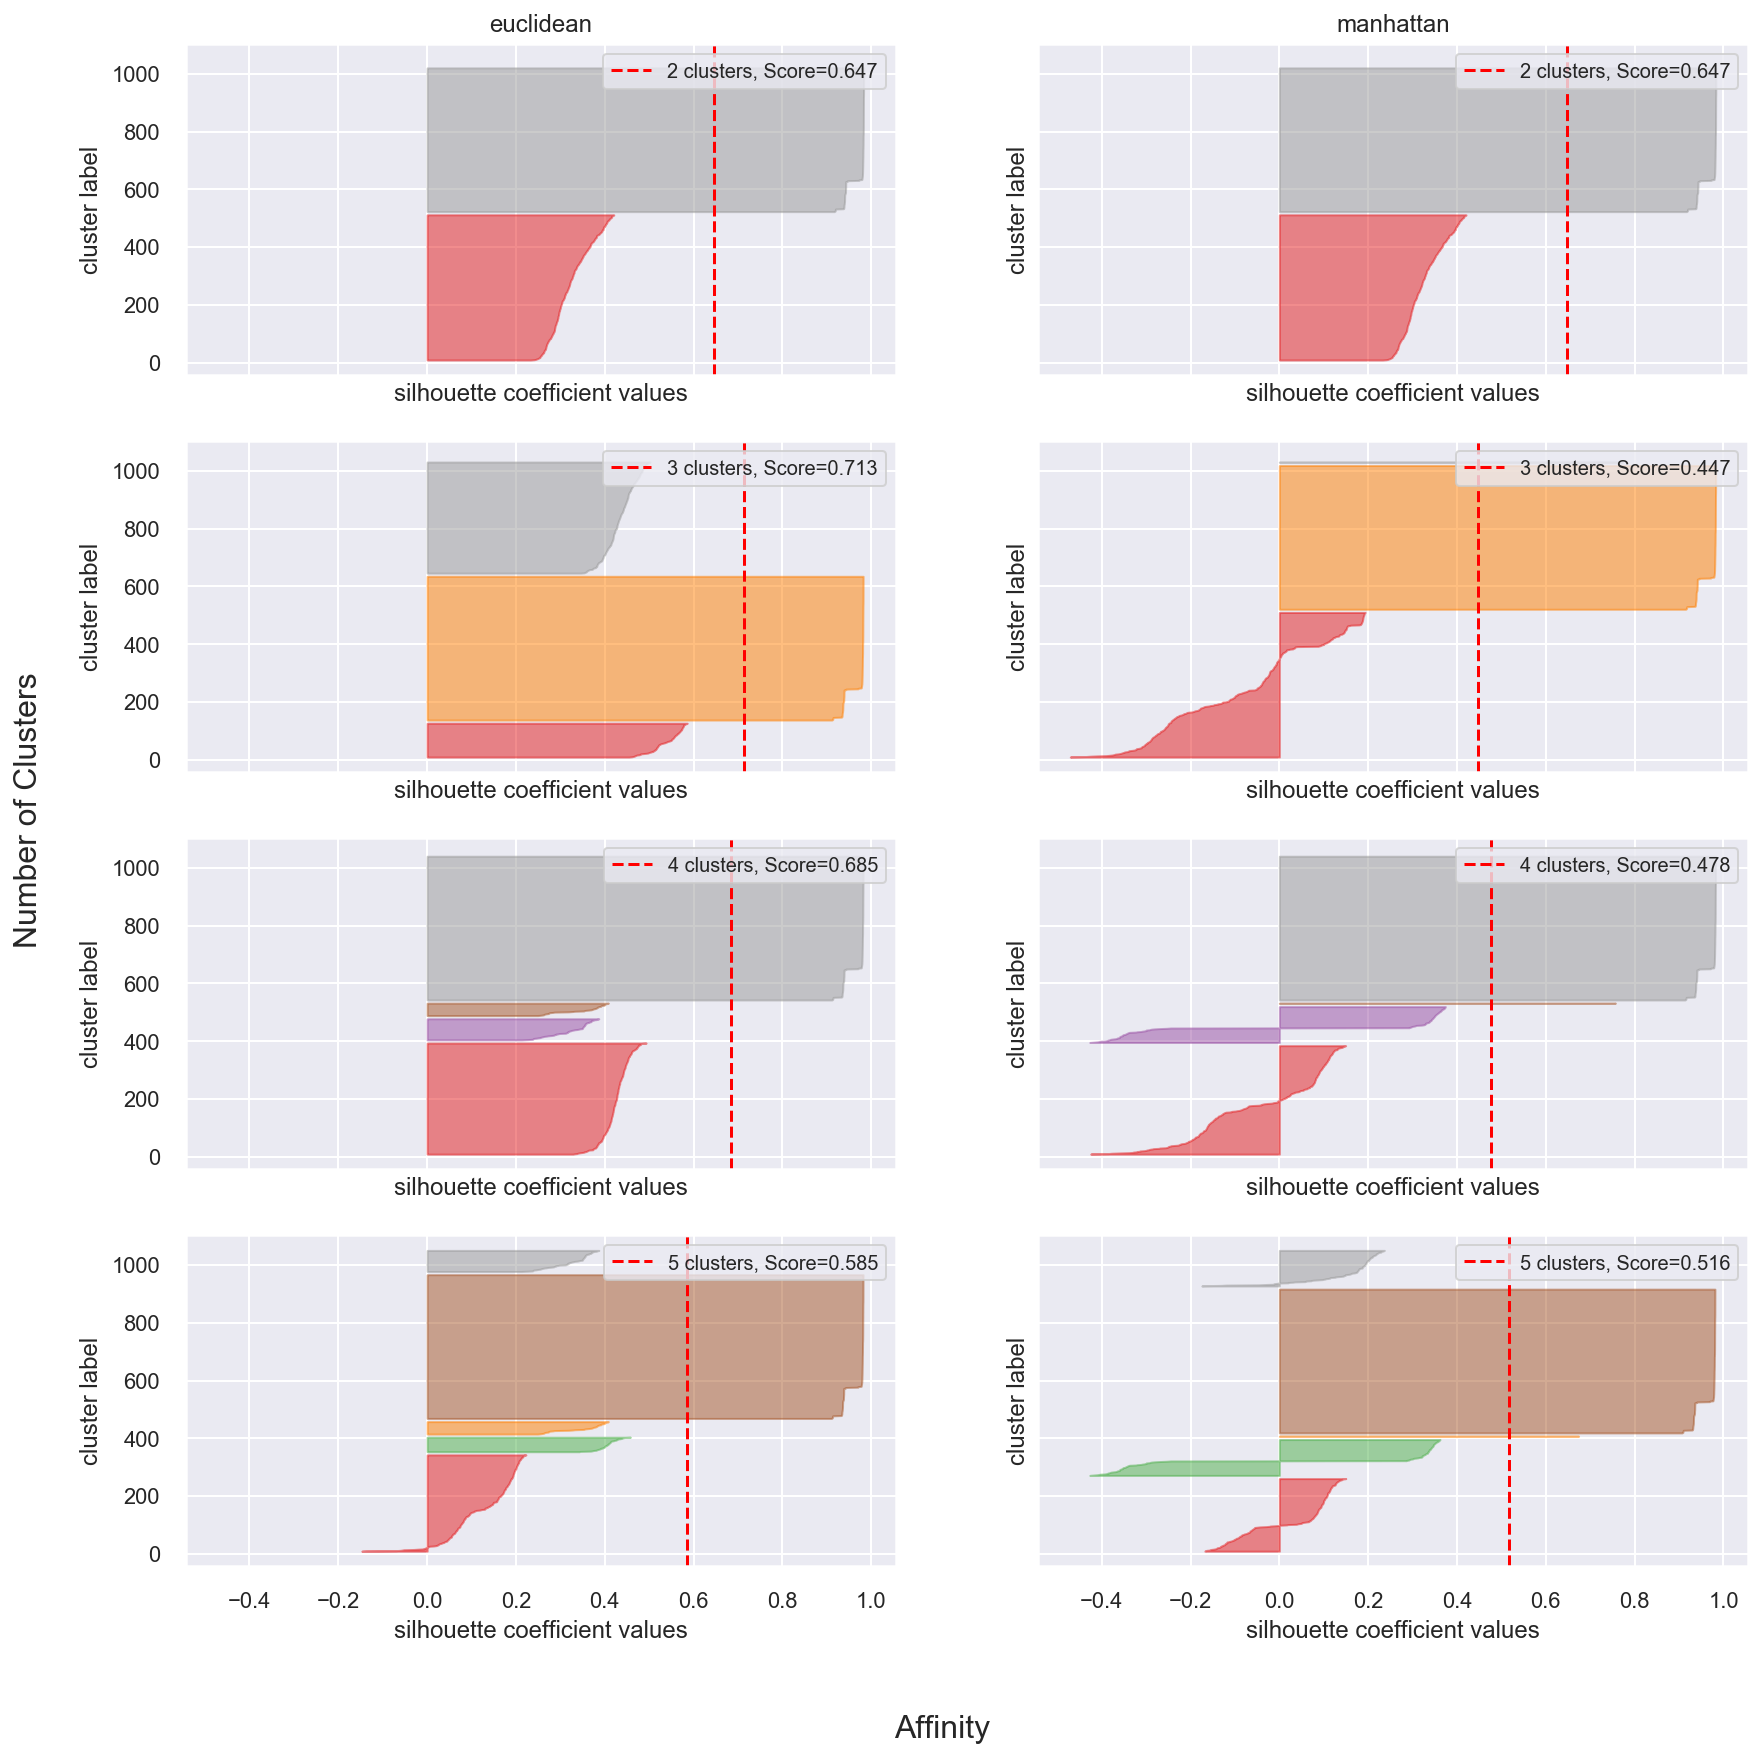

In [19]:
#initialize number of clusters as a list for looping
n_clusters = list(np.arange(2, 6))

#list for distance measures to be considered 
distance_measure = ["euclidean", "manhattan"]

# save labels to 3d array for  init_method, n_cluster combinations
y_agc_pr = np.zeros((len(n_clusters), X_projected.shape[0], 2))

fig, axs = plt.subplots(nrows=len(n_clusters), ncols=len(distance_measure), figsize=(14, 14), sharex=True, sharey=True)

# ignore minor warnings like deprecated attributes in new_version of sklearn
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for n_idx, n in enumerate(n_clusters):
        for dist_measure_idx, metric in enumerate(distance_measure):      
            agc = AgglomerativeClustering(n_clusters=n, affinity=metric, linkage="single")
            y_agc = agc.fit_predict(X_projected)
            y_agc_pr[n_idx, :, dist_measure_idx] = y_agc
            # Creating SilhouetteVisualizer and assigning it to an axis
            visualizer = agc_SilhouetteVisualizer(agc, ax=axs[n_idx, dist_measure_idx], is_fitted=True, legend=True)
            visualizer.fit(X_projected)
            # Setting subplot legends via axis
            axs[n_idx, dist_measure_idx].legend([f'{n} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
            # Setting subplot x and y labels
            axs[n_idx, dist_measure_idx].set(xlabel='silhouette coefficient values', ylabel='cluster label')

axs[0, 0].set_title("euclidean")
axs[0, 1].set_title("manhattan")

fig.text(0.5, 0.04, 'Affinity', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Number of Clusters', va='center', rotation='vertical', fontsize=16)

#### Comments

- We can draw the following conlcusions from the $Agglomerative$ $Clustering$ algorthim;

    - That, as observed in $K$-$Means$ clustering, at first glance, $n$_$clusters$ values of 2, 3, 4, and 5 do not yield acceptible clustering of the data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.
    
    - However, the silhouette analysis yields significantly differing results for both distance measures considered.
    
    - Since the $euclidean$ distance measure does not yield negative $silhouette$ $coefficients$, this is the preferred distance measure for this algorithm. 
    
- A plausible reason for the failure of this algorithm could be it's sensitivity to noise in the data, which appears in the recursive merging procedure.

- Although the clustering algorithm doesn't produce very good fit, it is seen from the plot that the number of clusters with the best score is $3$

#### Visualize Agglomerative Clustering Elbow

- In order to expand the the range of $n$_$clusters$ considered in the algorithm, we will plot the elbow (inertia) curves for a wide range of values. This will also help to consolidate the deductions from the silhouette analysis. 

- To aid direct comparison, the metric used in this plot is the $Calinski$-$Harabasz$ $Index$ which, the ratio of within to between cluster dispersion. The dispersion is defined as the sum of distances squared. 

- Higher scores of this index reflect dense, well separated clusters, which gives a reasonable standard concept of a cluster.

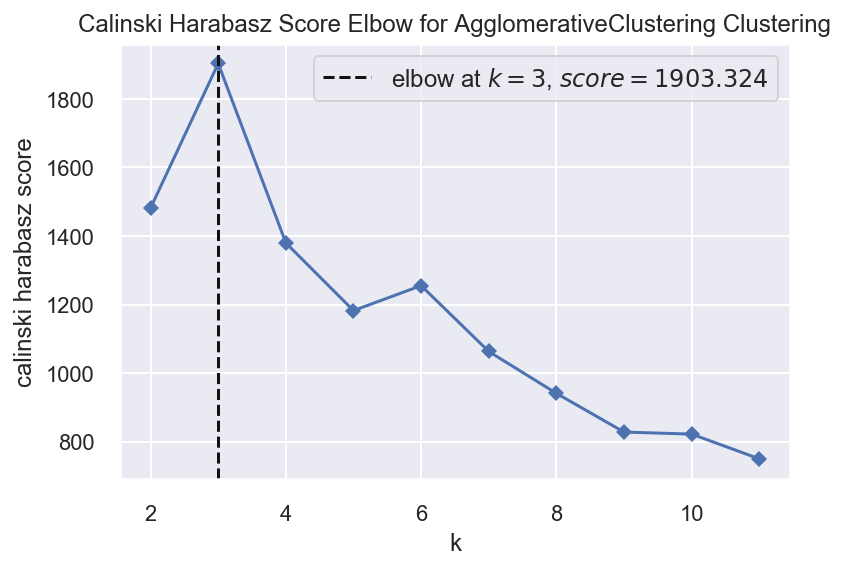

In [20]:
agc_model = AgglomerativeClustering(affinity="euclidean", linkage="single")
n_clusters_range = (2, 12)
visualizer = KElbowVisualizer(agc_model, k=n_clusters_range, metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(X_projected)
visualizer.show()

#### Comments

- It is evident from the silhouette analysis and the elbow plot that the optimal number of clusters predicted by the  $AgglomerativeClustering$ algorthim is $3$ since this results in the highest silhouette coefficient (nearest to +1) and $Calinski$-$Harabasz$ score, which by definition indicates highly dense clusters. 

- However, the analysis shows that n_clusters value of $3$ is still a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.

- Therefore, this model will be trained with $n$_$clusters$ = $3$ but other clustering algorithms will have to be tested to see if they produce better results/fits.

#### Fitted Model

- $Agglomerative$ $Clustering$ fittted with $n$_$clusters$ = $3$ and $affinity$ = $euclidean$

In [21]:
agc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="single")
y_agc = agc.fit_predict(X_projected)

#### DBSCAN -- Density-Based Clustering

- Despite its advantages over the $K$-$Means$ algorithm, $AgglomerativeClustering$, is particularly known to be sensitive to noise in the data--although this is not expected to significantly impact performance since some of the noise has been inadvertently fitered out by PCA.

- In addition, the number of clusters still has to be implicitly specified a-priori via the “resolution” hyperparameters. Changing the hyperparameters can easily result in fewer or more clusters which is somehow arbitrary and hence quite unsatisfactory as there is no obvious way to define an objective function for automated tuning of the hyperparameters.

- Out of all clustering algorithms, only Density-based (DBSCAN) allows clustering without specifying the number of clusters a-priori and can identify outliers as noise, instead of classifying them into a cluster, an area $AgglomerativeClustering$ crumbles.

- More so, such density based clustering algorithms are known indifferent to the shape of clusters and is also robust with respect to clusters with different density. Thus, the $DBSCAN$ algorithm will be tested.

- In this case the hyperparameters tuned are $min$_$samples$ and $eps$.

#### Below is a collapsed cell function for plotting. Please run the cell first

In [22]:
# yellowbrick.cluster.silhouette
# Implements visualizers using the silhouette metric for cluster evaluation.
#
# Author:   Benjamin Bengfort
# Author:   Rebecca Bilbro
# Created:  Mon Mar 27 10:09:24 2017 -0400
#
# Copyright (C) 2017 The scikit-yb developers
# For license information, see LICENSE.txt
#
# ID: silhouette.py [57b563b] benjamin@bengfort.com $

"""
Implements visualizers that use the silhouette metric for cluster evaluation.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np
import matplotlib.ticker as ticker

from sklearn.metrics import silhouette_score, silhouette_samples

from yellowbrick.utils import check_fitted
from yellowbrick.style import resolve_colors
from yellowbrick.cluster.base import ClusteringScoreVisualizer

## Packages for export

##########################################################################
## Silhouette Method for K Selection
##########################################################################


class db_SilhouetteVisualizer(ClusteringScoreVisualizer):
    """
    The Silhouette Visualizer displays the silhouette coefficient for each
    sample on a per-cluster basis, visually evaluating the density and
    separation between clusters. The score is calculated by averaging the
    silhouette coefficient for each sample, computed as the difference
    between the average intra-cluster distance and the mean nearest-cluster
    distance for each sample, normalized by the maximum value. This produces a
    score between -1 and +1, where scores near +1 indicate high separation
    and scores near -1 indicate that the samples may have been assigned to
    the wrong cluster.

    In SilhouetteVisualizer plots, clusters with higher scores have wider
    silhouettes, but clusters that are less cohesive will fall short of the
    average score across all clusters, which is plotted as a vertical dotted
    red line.

    This is particularly useful for determining cluster imbalance, or for
    selecting a value for K by comparing multiple visualizers.

    Parameters
    ----------
    estimator : a Scikit-Learn clusterer
        Should be an instance of a centroidal clustering algorithm (``KMeans``
        or ``MiniBatchKMeans``). If the estimator is not fitted, it is fit when
        the visualizer is fitted, unless otherwise specified by ``is_fitted``.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    colors : iterable or string, default: None
        A collection of colors to use for each cluster group. If there are
        fewer colors than cluster groups, colors will repeat. May also be a
        Yellowbrick or matplotlib colormap string.

    is_fitted : bool or str, default='auto'
        Specify if the wrapped estimator is already fitted. If False, the
        estimator will be fit when the visualizer is fit, otherwise, the
        estimator will not be modified. If 'auto' (default), a helper method
        will check if the estimator is fitted before fitting it again.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    silhouette_score_ : float
        Mean Silhouette Coefficient for all samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_score`.

    silhouette_samples_ : array, shape = [n_samples]
        Silhouette Coefficient for each samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_samples`.

    n_samples_ : integer
        Number of total samples in the dataset (X.shape[0])

    n_clusters_ : integer
        Number of clusters (e.g. n_clusters or k value) passed to internal
        scikit-learn model.

    y_tick_pos_ : array of shape (n_clusters,)
        The computed center positions of each cluster on the y-axis

    Examples
    --------

    >>> from yellowbrick.cluster import SilhouetteVisualizer
    >>> from sklearn.cluster import KMeans
    >>> model = db_SilhouetteVisualizer(KMeans(10))
    >>> model.fit(X)
    >>> model.show()
    """

    def __init__(self, estimator, ax=None, colors=None, is_fitted="auto", **kwargs):

        # Initialize the visualizer bases
        super(db_SilhouetteVisualizer, self).__init__(estimator, ax=ax, **kwargs)

        # Visual Properties
        # Use colors if it is given, otherwise attempt to use colormap which
        # which will override colors. If neither is found, default to None.
        # The colormap may yet still be found in resolve_colors
        self.colors = colors
        if "colormap" in kwargs:
            self.colors = kwargs["colormap"]

    def fit(self, X, y=None, **kwargs):
        """
        Fits the model and generates the silhouette visualization.
        """
        # TODO: decide to use this method or the score method to draw.
        # NOTE: Probably this would be better in score, but the standard score
        # is a little different and I'm not sure how it's used.

        if not check_fitted(self.estimator, is_fitted_by=self.is_fitted):
            # Fit the wrapped estimator
            self.estimator.fit(X, y, **kwargs)

        # Get the properties of the dataset
        self.n_samples_ = X.shape[0]
        self.n_clusters_ = np.unique(self.estimator.labels_).shape[0]

        # Compute the scores of the cluster
        labels = self.estimator.fit_predict(X)
        self.silhouette_score_ = silhouette_score(X, labels)
        self.silhouette_samples_ = silhouette_samples(X, labels)

        # Draw the silhouette figure
        self.draw(labels)

        # Return the estimator
        return self


    def draw(self, labels):
        """
        Draw the silhouettes for each sample and the average score.

        Parameters
        ----------

        labels : array-like
            An array with the cluster label for each silhouette sample,
            usually computed with ``predict()``. Labels are not stored on the
            visualizer so that the figure can be redrawn with new data.
        """

        # Track the positions of the lines being drawn
        y_lower = 10  # The bottom of the silhouette

        # Get the colors from the various properties
        color_kwargs = {"n_colors": self.n_clusters_}

        if self.colors is None:
            color_kwargs["colormap"] = "Set1"
        elif isinstance(self.colors, str):
            color_kwargs["colormap"] = self.colors
        else:
            color_kwargs["colors"] = self.colors

        colors = resolve_colors(**color_kwargs)

        # For each cluster, plot the silhouette scores
        self.y_tick_pos_ = []
        
        
        for idx in range(-1, self.n_clusters_):

            # Collect silhouette scores for samples in the current cluster
            values = self.silhouette_samples_[labels == idx]
            values.sort()

            # Compute the size of the cluster and find upper limit
            size = values.shape[0]
            y_upper = y_lower + size

            color = colors[idx]
            self.ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                values,
                facecolor=color,
                edgecolor=color,
                alpha=0.5,
            )

            # Collect the tick position for each cluster
            self.y_tick_pos_.append(y_lower + 0.5 * size)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10

        # The vertical line for average silhouette score of all the values
        self.ax.axvline(
            x=self.silhouette_score_,
            color="red",
            linestyle="--",
            label="Average Silhouette Score",
        )

        return self.ax


    def finalize(self):
        """
        Prepare the figure for rendering by setting the title and adjusting
        the limits on the axes, adding labels and a legend.
        """

        # Set the title
        self.set_title(
            ("Silhouette Plot of {} Clustering for {} Samples in {} Centers").format(
                self.name, self.n_samples_, self.n_clusters_
            )
        )

        # Set the X and Y limits
        # The silhouette coefficient can range from -1, 1;
        # but here we scale the plot according to our visualizations

        # l_xlim and u_xlim are lower and upper limits of the x-axis,
        # set according to our calculated max and min score with necessary padding
        l_xlim = max(-1, min(-0.1, round(min(self.silhouette_samples_) - 0.1, 1)))
        u_xlim = min(1, round(max(self.silhouette_samples_) + 0.1, 1))
        self.ax.set_xlim([l_xlim, u_xlim])

        # The (n_clusters_+1)*10 is for inserting blank space between
        # silhouette plots of individual clusters, to demarcate them clearly.
        self.ax.set_ylim([0, self.n_samples_ + (self.n_clusters_ + 1) * 10])

        # Set the x and y labels
        self.ax.set_xlabel("silhouette coefficient values")
        self.ax.set_ylabel("cluster label")

        # Set the ticks on the axis object.
        self.ax.set_yticks(self.y_tick_pos_)
        self.ax.set_yticklabels(str(idx) for idx in range(self.n_clusters_))
        # Set the ticks at multiples of 0.1
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

        # Show legend (Average Silhouette Score axis)
        self.ax.legend(loc="best")



Text(0.04, 0.5, 'Minimum number of samples')

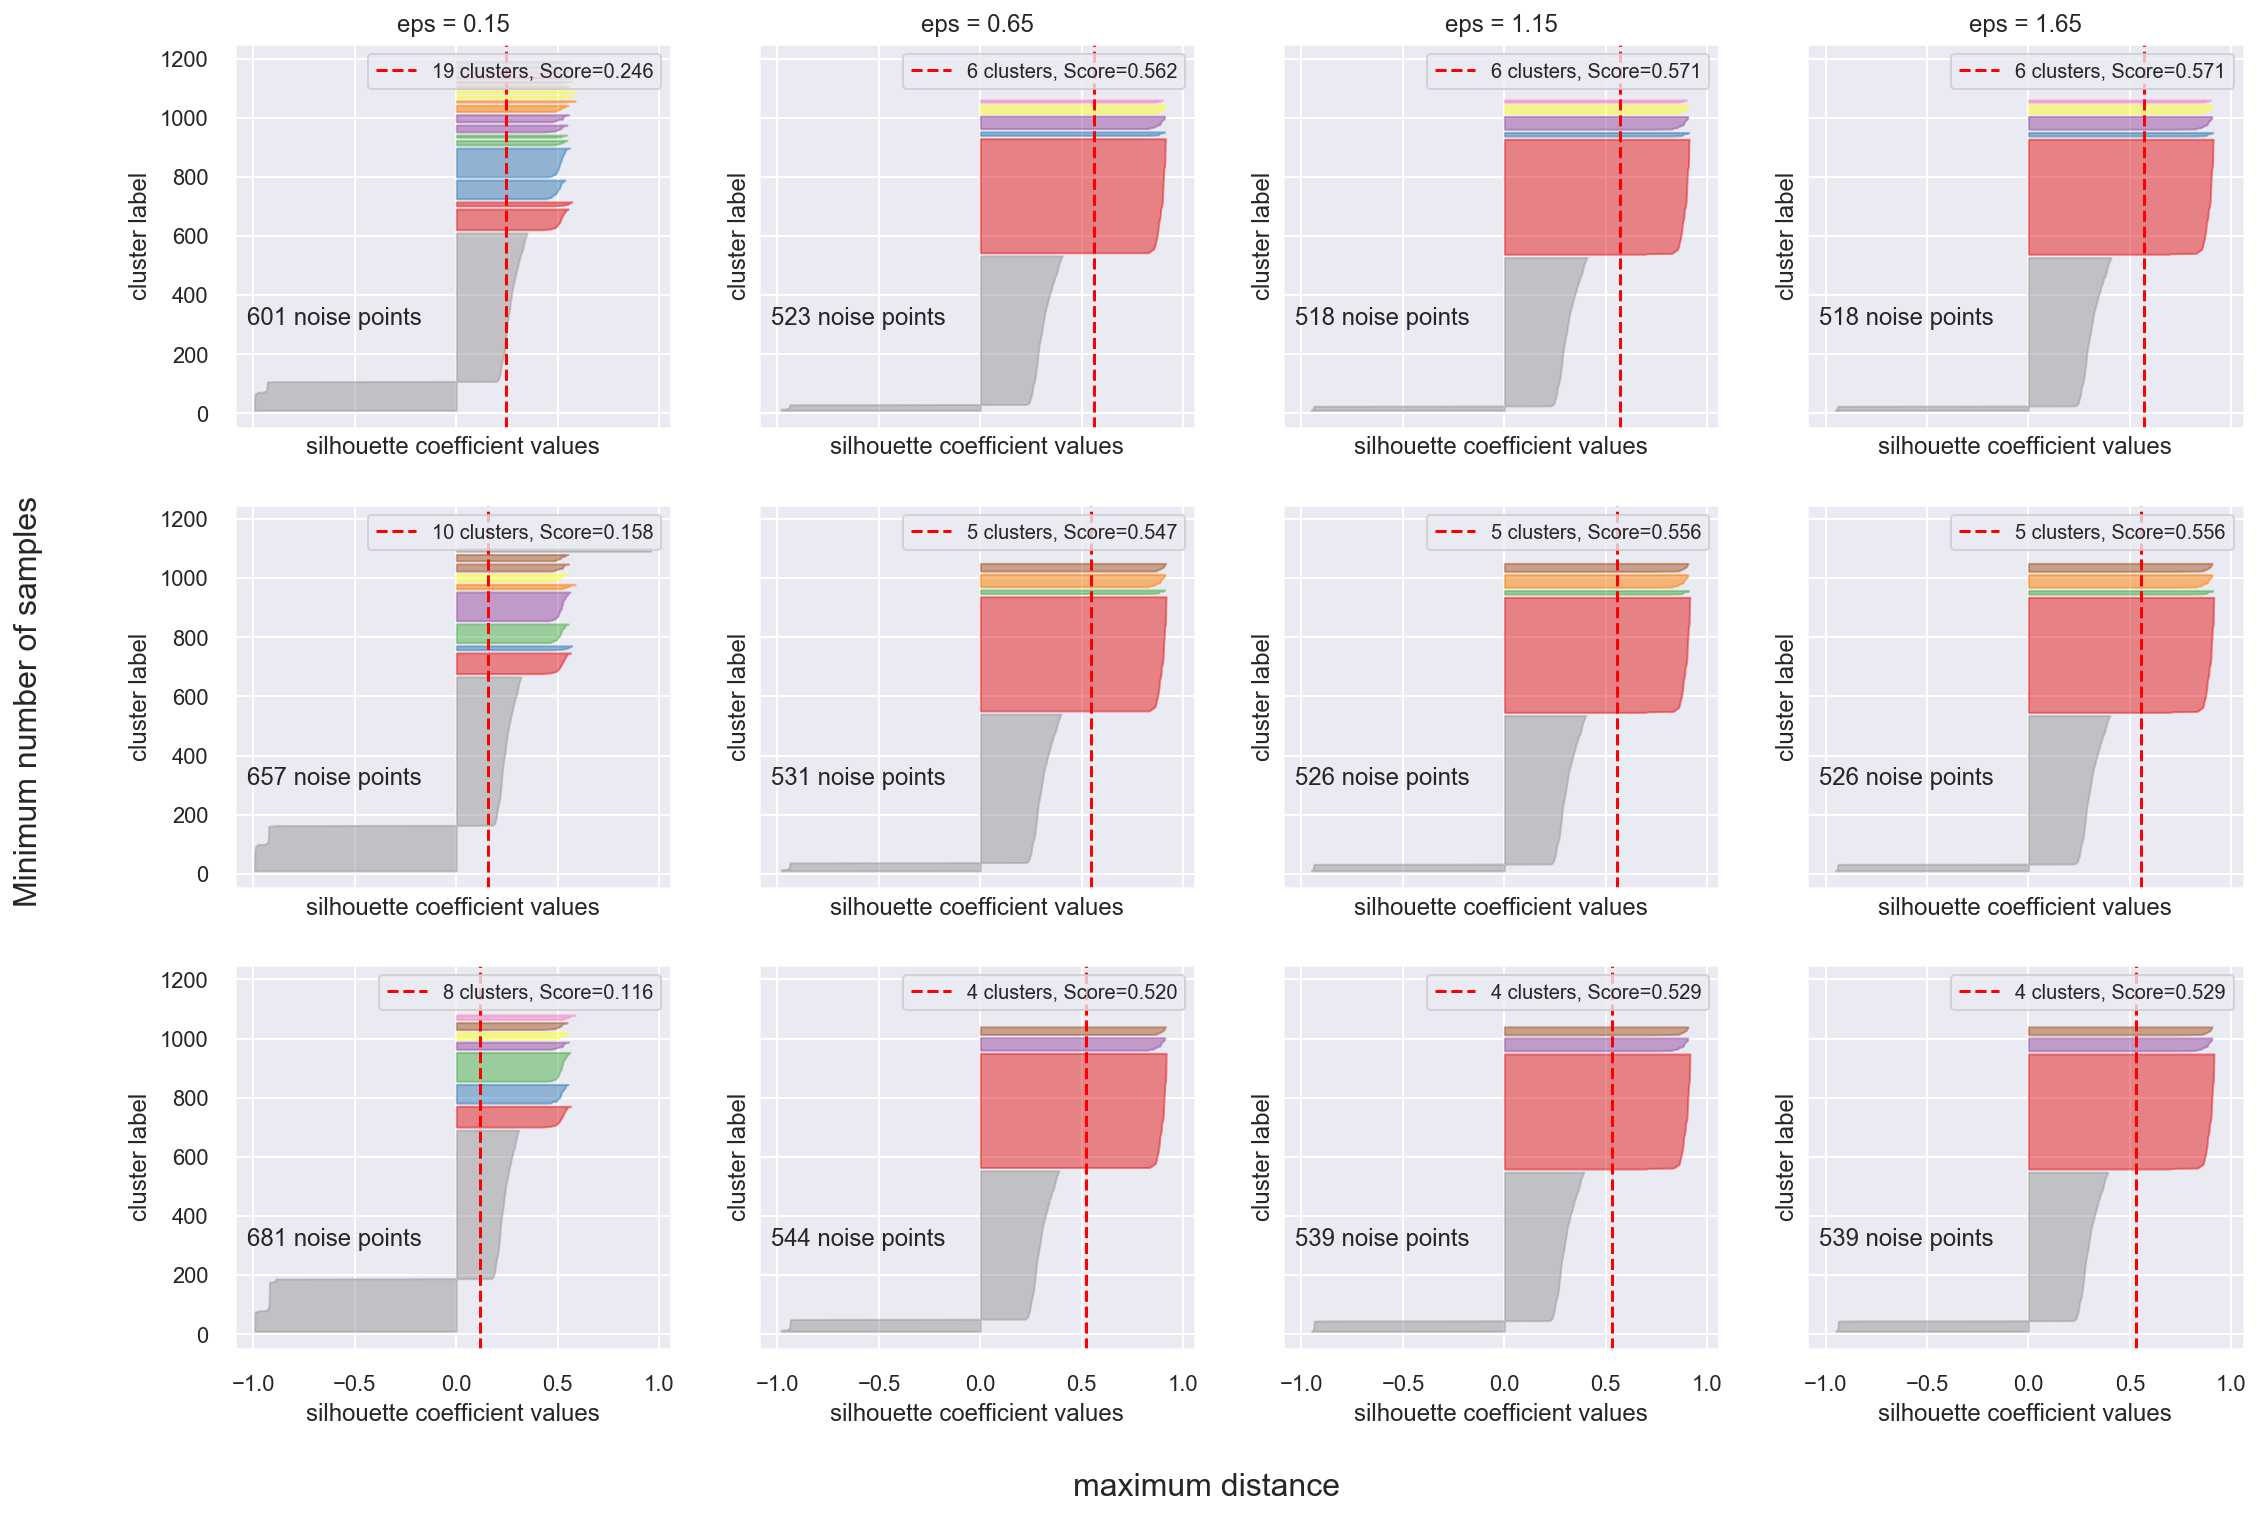

In [23]:
# list for range minimum sample size to be considered in hyperparameter tuning
min_samples = list(np.arange(5, 20, 5))

# list for range of 
eps = list(np.arange(0.15, 2.0, 0.5))

y_db_pr = np.zeros((len(min_samples), X_projected.shape[0], len(eps)))

fig, axs = plt.subplots(nrows=len(min_samples), ncols=len(eps), figsize=(18, 12), sharex=True, sharey=True)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i, n in enumerate(min_samples):
        for j, max_dist in enumerate(eps):
            db = DBSCAN(eps=max_dist, min_samples=n)
            y_db = db.fit_predict(X_projected)
            y_db_pr[i, :, j] = y_agc
            n_noise_ = len(db.labels_[db.labels_ == -1])
            # Creating SilhouetteVisualizer and assigning it to an axis
            visualizer = db_SilhouetteVisualizer(db, ax=axs[i, j], is_fitted=True, legend=True)
            visualizer.fit(X_projected)
            # Setting subplot legends via axis
            axs[i, j].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
            # Setting subplot x and y labels
            axs[i, j].set(xlabel='silhouette coefficient values', ylabel='cluster label')
            # setting estimated number of noise points
            
            axs[i, j].text(-0.6, 300, '{} noise points'.format(n_noise_), ha='center', wrap=True)            
            
for i in range(len(eps)):
    axs[0, i].set_title("eps = {}".format(eps[i]))

fig.text(0.5, 0.04, 'maximum distance', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Minimum number of samples', va='center', rotation='vertical', fontsize=16)


#### Comments

- The highest score in the silhouette plots ($0.571$) shown above corresponds to $n$_$clusters$ = $6$, returned for the  hyperparameter combination $min$_$samples$ = $5$ and $eps$ = $1.15$. This score is significantly lower than the scores produced by the $K$-$Means$ and $AgglomerativeClustering$ algorithms ($0.713$). To make matters worse, it is also seen that the algorithm classifies more than half of the data as noise points for all combinations of $min$_$samples$ and $eps$.  

- This quite surprising because it is expected that, by it's flexible and robust nature, such $Density$ $Based$ $Clustering$ algorithm should produce subtantially better results relative to the $Hierarchical$ and $Centroid-based$ $Clustering$ algorithms employed here. 

- This begs the question "Why does the $DBSCAN$ algorithm perform so poorly in comparison?"

- The quality of DBSCAN relies on the distance measure used. The default distance metric used in the trained algorithm above is the Euclidean distance. As stated before, particularly for high-dimensional data, the Euclidean distance metric can be rendered almost useless--failing to converge--due to the $curse$ $of$ $dimensionality$. Since finding an appropriate value for $eps$ depends on this measure, it makes it tuning the hyperparameter $eps$ practically impossible.

- This means that although, the other algorithm used here are plagued by this curse, this effect, is increasingly expressed in $DBSCAN$. 

- To verify this arguments, or perhaps remedy this, I approached the hyperparameter tuning from another perspective;

    - According to literature in [J. Sander et al. Data Mining and Knowledge Discovery (1998)](https://link.springer.com/article/10.1023/A:1009745219419), If the data has more than 2 dimensions, $min$_$samples$ should be chosen to be = $2$$x$$dim$, where $dim$ = the dimensions of the data. Therefore, since the reduced feature space has $dim$ = 150, $min$_$samples$ is chosen to be = $300$
    
    - This satisfies the rule of thub that $min$_$samples$ should be greater than or equal to the dimensionality of the data set
    
    - Next, to determine the optimal $eps$, I adopted the technique described in [Nadia Rahmah and Imas Sukaesih Sitanggang 2016 IOP Conf. Ser.: Earth Environ. Sci. 31 012012](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012). 
    
    - This technique calculates the average distance between each point and its k nearest neighbors, where k = the $min$_$samples$ value selected, $300$. 
    
    - The average k-distances are then plotted in ascending order on a k-distance graph. 
    
    - The optimal value for $eps$ is the point of maximum curvature (obtained from the second derivative and first derivative).

In [24]:
#### Import NearestNeighbors from Scikit-learn to calculate the average distance between each point and its n_neighbors
from sklearn.neighbors import NearestNeighbors

# obtained avarage distance between each point in the dataset and its 300 nearest neighbors.
min_samples = 300 
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_projected)

# obtain average distances
distances, indices = neighbors_fit.kneighbors(X_projected)

# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

plt.ylabel('$Sorted$ $Average$ $Distance$')
plt.xlabel('$Snapshots$ $Sorted$ $By$ $Distance$')

Text(0.5, 0, '$Snapshots$ $Sorted$ $By$ $Distance$')

- Eyeballing the plot above already shows that that there appears to be no clearly defined elbow for the sorted distances.

- To obtain this, the point of maximum curvature which is approximated by taking the ratio of the second derivative and the square of the first derivative. This is implimented in the algorithm shown below.

In [25]:
curve = []
for i in range(0, 1001):
    curve.append(1/(1+(distances[i-2] - distances[i-1])**2)**1.5)
    
curvature = []

for i in range(0, 1000):
    curvature.append((distances[i-2] + distances[i] - 2*distances[i-1])/2 * curve[i-1])

plt.plot(curvature)
plt.ylabel('$Approximate$ $Curvature$')
plt.xlabel('$Snapshots$ $Sorted$ $By$ $Distance$')

Text(0.5, 0, '$Snapshots$ $Sorted$ $By$ $Distance$')

- The maximum value of this curve is equivalent to the optimal value for $eps$.

In [26]:
eps = np.max(curvature)

print("Optimal value for $eps$ is {}".format(eps))

Optimal value for $eps$ is 5.464603089418702


- Next, we will again loop through combinations of $min$_$samples$ and $eps$ values slightly above ($min$_$samples$ = $350$, $eps$ = $8$) and below ($min$_$samples$ = $250$, $eps$ = $4$) the values estimated here to find the model of best fit.

Text(0.04, 0.5, 'Minimum number of samples')

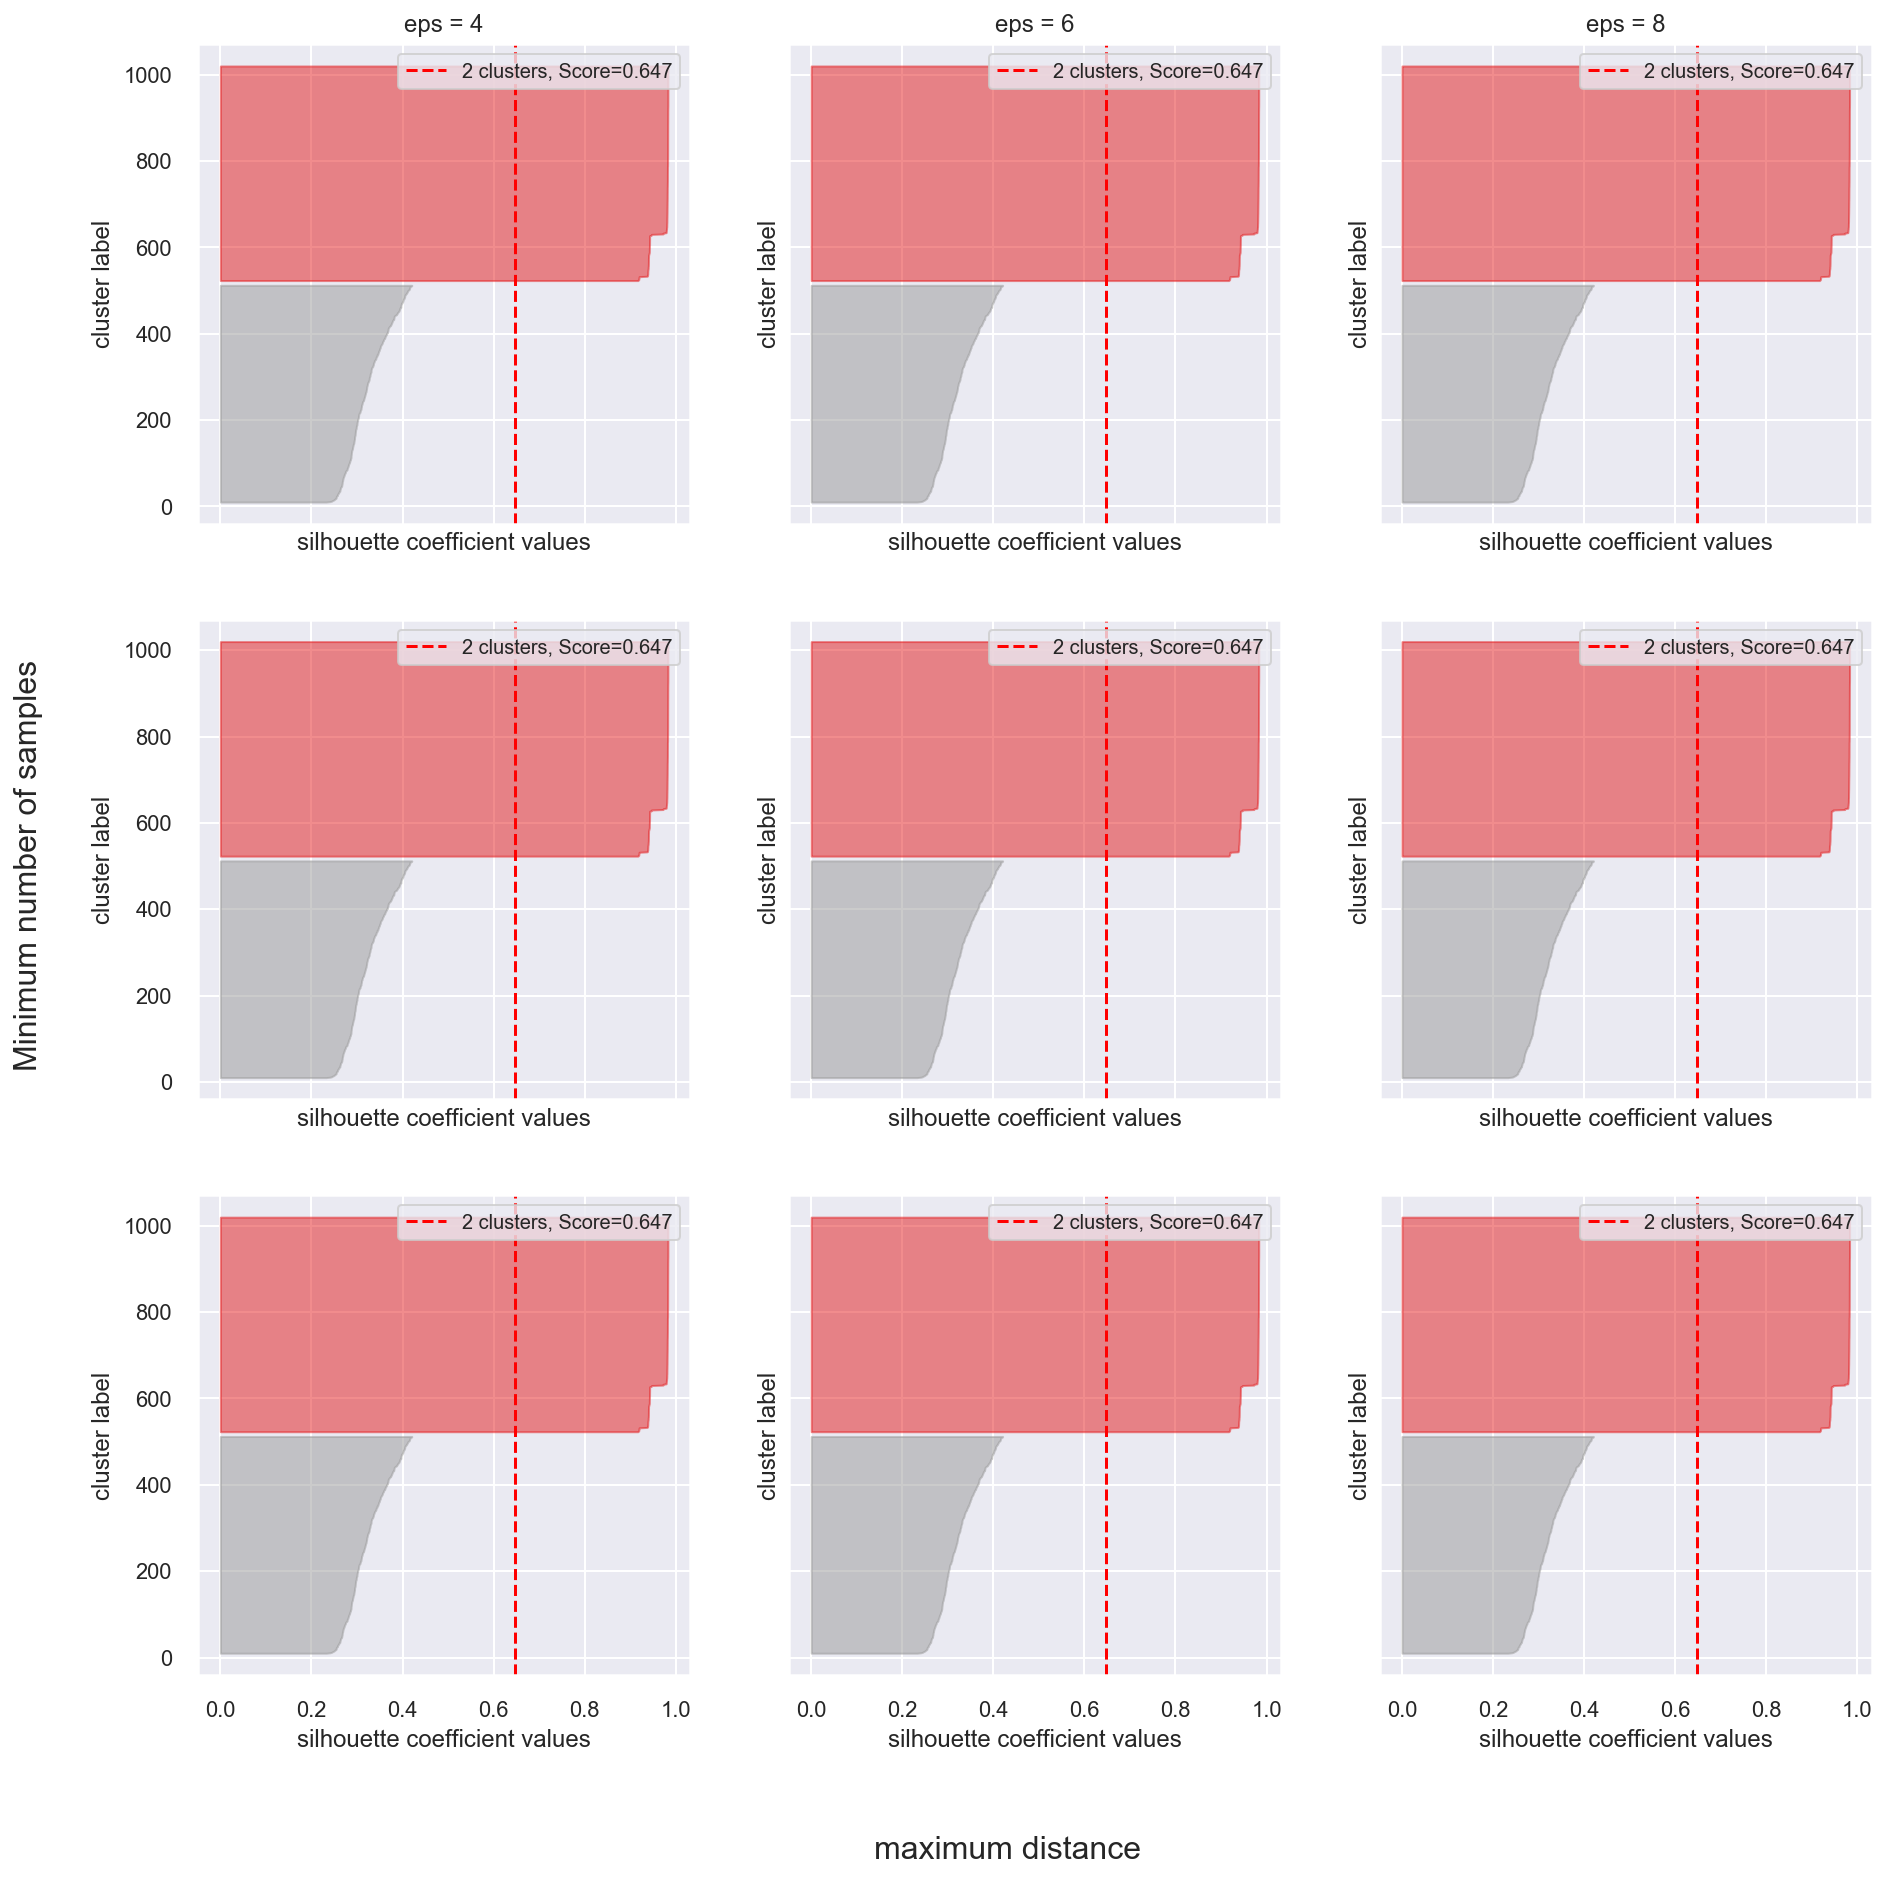

In [27]:
# list for range minimum sample size to be considered in hyperparameter tuning
min_samples = list(np.arange(250, 400, 50))

# list for range of 
eps = list(np.arange(4, 10, 2))

y_db_pr = np.zeros((len(min_samples), X_projected.shape[0], len(eps)))

fig, axs = plt.subplots(nrows=len(min_samples), ncols=len(eps), figsize=(15, 15), sharex=True, sharey=True)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i, n in enumerate(min_samples):
        for j, max_dist in enumerate(eps):
            db = DBSCAN(eps=max_dist, min_samples=n)
            y_db = db.fit_predict(X_projected)
            y_db_pr[i, :, j] = y_agc
            # Creating SilhouetteVisualizer and assigning it to an axis
            visualizer = db_SilhouetteVisualizer(db, ax=axs[i, j], is_fitted=True, legend=True)
            visualizer.fit(X_projected)
            # Setting subplot legends via axis
            axs[i, j].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
            # Setting subplot x and y labels
            axs[i, j].set(xlabel='silhouette coefficient values', ylabel='cluster label')

for i in range(len(eps)):
    axs[0, i].set_title("eps = {}".format(eps[i]))

fig.text(0.5, 0.04, 'maximum distance', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Minimum number of samples', va='center', rotation='vertical', fontsize=16)

#### Comments

- We can draw the following conlcusions from the silhouette analysis of the $Density$ $Based$ $Clustering$ algorthim;

    - The silhouette coefficients do not marginally change for combinations of $min$_$samples$ and $eps$ values slightly above ($min$_$samples$ = $350$, $eps$ = $8$) and below ($min$_$samples$ = $250$, $eps$ = $4$).
    
    - This suggests that the technique applied here for obtaining the optimal values for $min$_$samples$ and $eps$ produces a good fit. Therefore, $min$_$samples$ is chosen to be $300$ and $eps$, $6.19$ for the tranined model.
    
    - There appears to be a striking similarity in the clustering (labelling) results and average silhouette coefficients ($0.647$) obtained here and those obtained for both $K$-$Means$ and $AgglomerativeClustering$ whith $n$_$clusters$ = $2$. 
    
    - This is quite interesting because the initial combination of hyperparameters considered for $DBSCAN$ yielded no such results, validating the results obtained by the hyperparamter tuning techinique. 
    
    - It is important to note that although this tuning techinique produces a better fit with $min$_$samples$ = $300$ and $eps$ = $6.19$, about half of the samples are in the cluster with below average silhouette score. 

#### Fitted Model

- $DBSCAN$ fittted with $min$_$samples$ = $300$ and $eps$ = $6.19$

In [28]:
db = DBSCAN(eps=6.19, min_samples=300)
y_db = db.fit_predict(X_projected)

## Model Comparison

- Having obtained the optimized hyperparameters for the three algorithms considered, Which of these models produces optimal clustering results?

#### Fitted Models

In [29]:
kmeans = KMeans(n_clusters=3, init="k-means++")
y_kmeans = kmeans.fit_predict(X_projected)

agc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="single")
y_agc = agc.fit_predict(X_projected)

db = DBSCAN(eps=6.19, min_samples=300)
y_db = db.fit_predict(X_projected)

- Let's visualize their silhouette plots side by side.

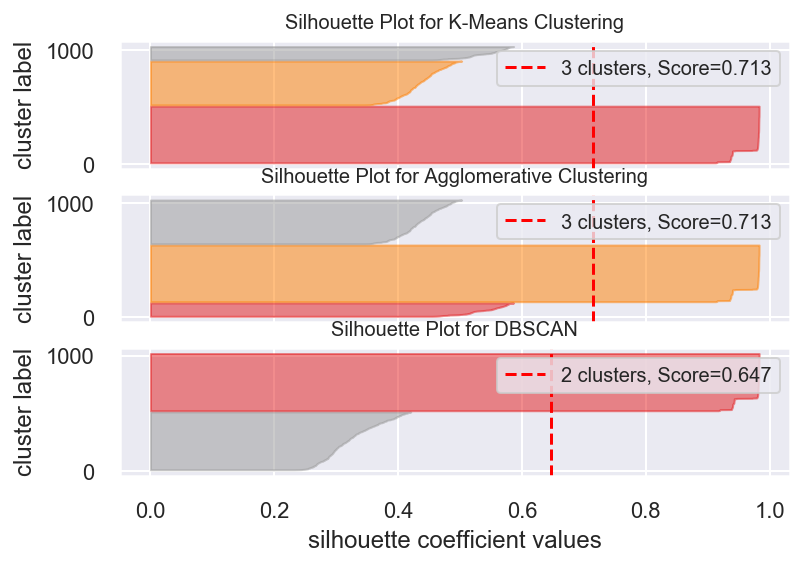

In [30]:
fig, axs = plt.subplots(nrows=3, ncols=1)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Creating SilhouetteVisualizer for K-means
    visualizer = SilhouetteVisualizer(kmeans, ax=axs[0], is_fitted=True, legend=True)
    visualizer.fit(X_projected)
    # Setting subplot legends via axis
    axs[0].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
    # Setting subplot x and y labels
    axs[0].set(xlabel='silhouette coefficient values', ylabel='cluster label')
    axs[0].set_title("Silhouette Plot for K-Means Clustering", fontsize=10)

    # Creating SilhouetteVisualizer for Agglomerative Clustering
    visualizer = agc_SilhouetteVisualizer(agc, ax=axs[1], is_fitted=True, legend=True)
    visualizer.fit(X_projected)
    axs[1].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
    # Setting subplot x and y labels
    axs[1].set(xlabel='silhouette coefficient values', ylabel='cluster label')
    axs[1].set_title("Silhouette Plot for Agglomerative Clustering", fontsize=10)

    # Creating SilhouetteVisualizer for DBSCAN
    visualizer = db_SilhouetteVisualizer(db, ax=axs[2], is_fitted=True, legend=True)
    visualizer.fit(X_projected)
    axs[2].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
    # Setting subplot x and y labels
    axs[2].set(xlabel='silhouette coefficient values', ylabel='cluster label')
    axs[2].set_title("Silhouette Plot for DBSCAN", fontsize=10)


#### Comments

- At first glance, it appears that both $K$-$Means$ and $AgglomerativeClustering$ produce the best results when the average silhouette coefficient alone is used as an assay, because they yield higher scores relative to $DBSCAN$. 

- However, it would be naive to completely rule out the $DBSCAN$ algorithm based on this alone. This is due to wide fluctuations in the thickness of the silhouette plots for the $K$-$Means$ and $AgglomerativeClustering$ algorithms predicting $n$_$clusters$ = $3$.  

- Since the ground truth label assignments are known, the performs of all three clustering algorithms can further be evaluated using the following metrics;

    - $Adjusted$ $Rand$ $Index$ ($ARI$):
    
        - This measures the similarity of the two data clusterings bouded below by 0.0 and above by 1.0
        - Perfect labeling is scored 1.0
        
    - $Adjusted$ $Mutual$ $Information$ ($AMI$):
    
        - Similar to $ARI$, This measures agreement of the two data clusterings, ignoring permutations, bouded below by 0.0 and above by 1.0
        - Perfect labeling is scored 1.0   
        
    - $Homogeneity$ and $Completeness$:
    
        - Homogeneity is a measure of the purity of each cluster. Checks if each cluster contains only members of a single class. This is boudned below by 0.0 and above by 1.0
        - Completeness captures if all members of a given class are assigned to the same cluster. This is also boudned below by 0.0 and above by 1.0 
        - Their harmonic mean called $V$-$measure$
        
    - Mathematical formalisms of these metrics can be found [here](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

In [31]:
metrics_on_data = pd.DataFrame(columns=["ARI", "AMI", "Homogeneity", "Completeness", "Silhouette"], 
                                   index=["K-Means", "Agglomerative Clustering", "DBSCAN"],
                                   dtype=float)


metrics_on_data.loc["K-Means", "ARI"] = metrics.adjusted_rand_score(y_kmeans, flags)
metrics_on_data.loc["K-Means", "AMI"] = metrics.adjusted_mutual_info_score(y_kmeans, flags)
metrics_on_data.loc["K-Means", "Homogeneity"] = metrics.homogeneity_score(y_kmeans, flags)
metrics_on_data.loc["K-Means", "Completeness"] = metrics.completeness_score(y_kmeans, flags)
metrics_on_data.loc["K-Means", "Silhouette"] = metrics.silhouette_score(X_projected, y_kmeans, metric='euclidean')

metrics_on_data.loc["Agglomerative Clustering", "ARI"] = metrics.adjusted_rand_score(y_agc, flags)
metrics_on_data.loc["Agglomerative Clustering", "AMI"] = metrics.adjusted_mutual_info_score(y_agc, flags)
metrics_on_data.loc["Agglomerative Clustering", "Homogeneity"] = metrics.homogeneity_score(y_agc, flags)
metrics_on_data.loc["Agglomerative Clustering", "Completeness"] = metrics.completeness_score(y_agc, flags)
metrics_on_data.loc["Agglomerative Clustering", "Silhouette"] = metrics.silhouette_score(X_projected, y_agc, metric='euclidean')

metrics_on_data.loc["DBSCAN", "ARI"] = metrics.adjusted_rand_score(y_db, flags)
metrics_on_data.loc["DBSCAN", "AMI"] = metrics.adjusted_mutual_info_score(y_db, flags)
metrics_on_data.loc["DBSCAN", "Homogeneity"] = metrics.homogeneity_score(y_db, flags)
metrics_on_data.loc["DBSCAN", "Completeness"] = metrics.completeness_score(y_db, flags)
metrics_on_data.loc["DBSCAN", "Silhouette"] = metrics.silhouette_score(X_projected, y_db, metric='euclidean')

### Metric Heatmap

In [32]:
sns.heatmap(data=metrics_on_data, annot=True)

#### Comments

- The heatmap shows that of the three algorithms, $DBSCAN$ has the highest scores ($approx$ $1$) for the $ARI$, $AMI$, $Homogeneity$ and $Completeness$ metrics and the lowest $Silhouette$ $Score$. 

- By virtue of their definition, this means that despite the comparatively lower $Silhouette$ $Score$, the $DBSCAN$ clustering algorithm, with $n$_$clusters$ = $2$, yields the predictions with the highest aggrements and similarity to the ground truth labels while maintining the purity of each cluster and ensuring that as many memebers of a given class are are assigned to the correct cluster for completeness. 

- Therefore, the optimal clustering model for this problem is the $DBSCAN$ algorithm with $min$_$samples$ = $300$ and $eps$ = $6.19$ which yields $n$_$clusters$ = $2$.

- As seen in previous silhouette analysis, It is worth noting that similar results can be obtained with the $K$_$means$ and $Agglomerative$ $Clustering$ algortithms trained with $n$_$clusters$ = $2$

#### Save Results From Optimal Model

In [33]:
db = DBSCAN(eps=6.19, min_samples=300)
y_db = db.fit_predict(X_projected)
question_one = pd.DataFrame(columns=["labels_predicted"], index=list(np.arange(0,X_projected.shape[0])), dtype=float)
question_one["labels_predicted"] = y_db
question_one.to_csv("Final_question_one.csv")

# Question Two

In [34]:
from keras import models
from keras import layers
from keras import regularizers
from keras import losses
from keras import metrics 
from keras import optimizers
from keras.utils.np_utils import to_categorical

In [35]:
# Load Training Data From Disc
data = pd.read_csv("exam_raw.csv")

- Here, we'll take a brief look at the data for the purpose of exploratory analysis and description of the overall data.

In [36]:
data.head()

Vmag    Plx  e_Plx    B-V SpType
0  9.10   3.54   1.39  0.482     F5
1  9.27  21.90   3.10  0.999    K3V
2  6.61   2.81   0.63 -0.019     B9
3  8.06   7.75   0.97  0.370    F0V
4  8.55   2.87   1.11  0.902  G8III

In [37]:
data.tail()

Vmag    Plx  e_Plx    B-V SpType
81935  9.22   0.71   2.26  0.347     A3
81936  7.20  13.13   0.99  0.443   F5IV
81937  7.74   3.01   1.03  1.378  K1III
81938  7.21   3.14   0.69  0.020     A0
81939  8.71   2.34   0.76  1.015     K0

#### Missing Data?

- An important question to ask is how many observation, if any, have missing data and what proportion of entire set this represents

In [38]:
print("Proportion of missing values")
print(data.isnull().sum()*100/len(data))
print("\n")
print("Proportion of missing values")
data.isna().sum()*100/len(data)

Proportion of missing values
Vmag      0.000000
Plx       0.000000
e_Plx     0.000000
B-V       0.000000
SpType    2.434708
dtype: float64


Proportion of missing values


Vmag      0.000000
Plx       0.000000
e_Plx     0.000000
B-V       0.000000
SpType    2.434708
dtype: float64

#### Clean Data

- The exploratory analysis above reveals that ~$2$% of the obervation have missing $SpType$ entries (labels).  

- To avoid training bias, the rows with missing labels will be droped using $dropna()$ method.

- Subsequently, we'll drop rows where $e_{plx} \approx Plx$.

- The algorithm to use for this would be checking if the rounded up values of $P_{lx}$ and $e_{Plx}$ are equal. The observation is kept if otherwise. 

- This filtering criteria yields a Tolerance limit ~ $0.8$, indicating that observations with parallax error within $0.8$ of the parallax itself should be dropped.

In [39]:
# drop missing data
data = data.dropna()

# drop observations with "e_Plx" ~ "Plx"
data = data[np.round(data["e_Plx"]) != np.round(data["Plx"])]

In [40]:
data.shape

(73801, 5)

- Next, rows that to not satisfy the Luminousity class in the SpType string label will be dropped

In [41]:
# drop observations that do not satify (endwith) the luminousity class "I", "II", "III", "IV", "V", "VI", "VII"

data = data[data["SpType"].str.endswith(("I", "II", "III", "IV", "V", "VI", "VII"))]

data.head()

Vmag    Plx  e_Plx    B-V SpType
1  9.27  21.90   3.10  0.999    K3V
3  8.06   7.75   0.97  0.370    F0V
4  8.55   2.87   1.11  0.902  G8III
7  8.59  10.76   1.10  0.489    F6V
9  8.43   4.06   1.16  1.484  K4III

- Physical examination of the data reveals that observations that do not confirm to the configuration -- where the $SpType$ enrty is a string with first two characters specifing MK classification out of $“OBAFGKMRS”$, followed by single digit integer and followed by Luminosity class denoted by roman numerals from I to VII -- exist in the data. 

- Examples are shown below

In [42]:
data[data["SpType"].str.len() > 5]

Vmag    Plx  e_Plx    B-V     SpType
98     8.29   2.83   1.09  1.183  K1IIICNIV
927    6.86   6.48   0.94  1.096  K1IIICNIV
4055   6.61  13.28   0.79  0.905  K0IIICNIV
5096   8.20   5.02   1.02  1.183  K2IIICNII
24854  7.72   5.44   0.95  1.225  K2IIICNII
25527  7.90   4.75   0.66  1.073  K1IIICNIV
31663  9.10   3.11   1.40  1.214  K0IIICNII
39116  5.49   4.27   0.68  1.345  K2IIICNII
43068  8.57   3.28   1.08  1.222  K2IIICNII
65848  5.70  11.31   0.60  1.169  K1IIICNII
75929  6.96   2.66   0.87  1.490   G6IICNIV

- Such observations with bad data be dropped as well. 

- Since the maximum possible length of such a string is $Five$, any observations with string labels longer than $Five$ will be dropped. 

In [43]:
# drop observations where the lenght of the "SpType" data is > 5
data = data[data["SpType"].str.len() <= 5]
data.head()

Vmag    Plx  e_Plx    B-V SpType
1  9.27  21.90   3.10  0.999    K3V
3  8.06   7.75   0.97  0.370    F0V
4  8.55   2.87   1.11  0.902  G8III
7  8.59  10.76   1.10  0.489    F6V
9  8.43   4.06   1.16  1.484  K4III

- Lastly, I will investigate the $SpType$ column to confirm that the $SpType$ enrty is a string with first letter specifing MK classification out of $“OBAFGKMRS”$.

In [44]:
# view data points that do not have MK classifications "O", "B", "A", "F", "G", "K", "M", "R", "S"

data[~ data["SpType"].str.upper().str.startswith(("O", "B", "A", "F", "G", "K", "M", "R", "S"))].head()

Vmag    Plx  e_Plx    B-V SpType
306    8.12   2.15   1.05  2.530   C5II
1797   9.52  10.27   1.08  0.735   C6II
12686  5.71   2.48   0.56  2.419   C5II
19144  9.18  -1.15   1.48  2.750   C4II
20389  8.96   1.26   1.51  2.928   C5II

- Again, such bad observations will be dropped.

In [45]:
# drop data points that do not have MK classifications "O", "B", "A", "F", "G", "K", "M", "R", "S"

data = data[data["SpType"].str.upper().str.startswith(("O", "B", "A", "F", "G", "K", "M", "R", "S"))]
data.head()

Vmag    Plx  e_Plx    B-V SpType
1  9.27  21.90   3.10  0.999    K3V
3  8.06   7.75   0.97  0.370    F0V
4  8.55   2.87   1.11  0.902  G8III
7  8.59  10.76   1.10  0.489    F6V
9  8.43   4.06   1.16  1.484  K4III

#### Feature Engineering

- Now, the $e_{plx}$ column will be dropped to extract feature vectors for training

- These will then be saved to file titled $CleanedData.csv$

In [46]:
data_train = data.drop("e_Plx", axis=1)

In [47]:
data_train.to_csv("cleaned_data.csv", header=True, index=False) 

#### Label Encoding

- Here, the labels will be encoded using the $LabelEncoder$ transformer in order to preserve the ordering of the labels 

- we'll do this by first creating a fifth column corresponding to the Luminous Class of the original labels.

In [48]:
# List containing all possible classes

luminousclass = ["I", "II", "III", "V", "IV", "VI", "VII"]

In [49]:
# Iterate over classes in the list and set Luminousity class appropriately

for clas in luminousclass:
    data_train.loc[data_train["SpType"].str.endswith(clas), "Luminousity Class"] = clas

In [50]:
data_train.head()

Vmag    Plx    B-V SpType Luminousity Class
1  9.27  21.90  0.999    K3V                 V
3  8.06   7.75  0.370    F0V                 V
4  8.55   2.87  0.902  G8III               III
7  8.59  10.76  0.489    F6V                 V
9  8.43   4.06  1.484  K4III               III

- Since Luminous Class has been extracted, the labels can now be encoded using LabelEncoder

In [51]:
le = LabelEncoder()

In [52]:
data_train["label"] = le.fit_transform(data_train["Luminousity Class"])

data_train.to_csv("cleaned_data2.csv", header=True, index=False)

In [53]:
data_train.head()

Vmag    Plx    B-V SpType Luminousity Class  label
1  9.27  21.90  0.999    K3V                 V      3
3  8.06   7.75  0.370    F0V                 V      3
4  8.55   2.87  0.902  G8III               III      1
7  8.59  10.76  0.489    F6V                 V      3
9  8.43   4.06  1.484  K4III               III      1

#### Examine Exam Question Data

- Now that the raw data has been cleaned, we can examine the exam question data to see if missing data exists

In [54]:
# Load Exam Data

exam_data = pd.read_csv("exam_question.csv")
exam_data = exam_data[["Vmag", "Plx", "B-V"]]

- Do missing data exist?

In [55]:
print("Proportion of missing values")
print(exam_data.isnull().sum())
print("\n")
print("Proportion of missing values")
print(exam_data.isna().sum())

Proportion of missing values
Vmag    0
Plx     0
B-V     0
dtype: int64


Proportion of missing values
Vmag    0
Plx     0
B-V     0
dtype: int64


- This function does not identify any missing data, however, physical examination of the data shows there several missing values. 

- To remedy this, I convert each feature to numeric values and use the error paramter to parse invalid data as NaN


In [56]:
exam_data["Vmag"] = pd.to_numeric(exam_data["Vmag"], downcast="float", errors='coerce')
exam_data["Plx"] = pd.to_numeric(exam_data["Plx"], downcast="float", errors='coerce')
exam_data["B-V"] = pd.to_numeric(exam_data["B-V"], downcast="float", errors='coerce')

- Now, we check again for missing values

In [57]:
print("Number of missing values")
print(exam_data.isnull().sum())
print("\n")
print("Number of missing values")
print(exam_data.isna().sum())

Number of missing values
Vmag    0
Plx     2
B-V     1
dtype: int64


Number of missing values
Vmag    0
Plx     2
B-V     1
dtype: int64


- The code above shows that missing data exist

- Since the $SimpleImputer$ does not permit flexibility of the imputing strategy, the $IterativeImputer$, which linear regresses the training data, is favorable for such proportion of missing data.

In [58]:
X_raw = data_train[["Vmag", "Plx", "B-V"]]

imp = IterativeImputer(max_iter=10, random_state=0)

imp.fit(X_raw)

X_exam = imp.transform(exam_data)

exam_data[["Vmag", "Plx", "B-V"]] = X_exam

#### Select Features and Label

- Here, we select the $Vmag$, $Plx$ and $B_V$ columns as features and $Label$ column as the $y$ labels

In [59]:
X = data_train[["Vmag", "Plx", "B-V"]]

In [60]:
y = data_train["label"]

#### Exploratory analysis

- A pairplot is uselful to visualize the correlation and distribution of the dataset.

In [61]:
g = sns.pairplot(data_train, hue='label', markers="+")

- The exploratory analysis shown above already indicates that the features require some data preprocessing or transformations because the raw features exists on different scales with significant varaince in numerical values. Added to this is the fact that some classes appear to have a bimodal distribution of certain features.

- Generally, the features do not appear to have a gaussian distribution, however, the $B_V$ and $V_{mag}$ features have some semblance of such distribution. 

- This tempts one to apply preprocessing technqiues like the $MinMaxScaler$

In [62]:
# Scale Using MinMaxScaler

scaler_minmax = MinMaxScaler()
Xs = scaler_minmax.fit_transform(X)

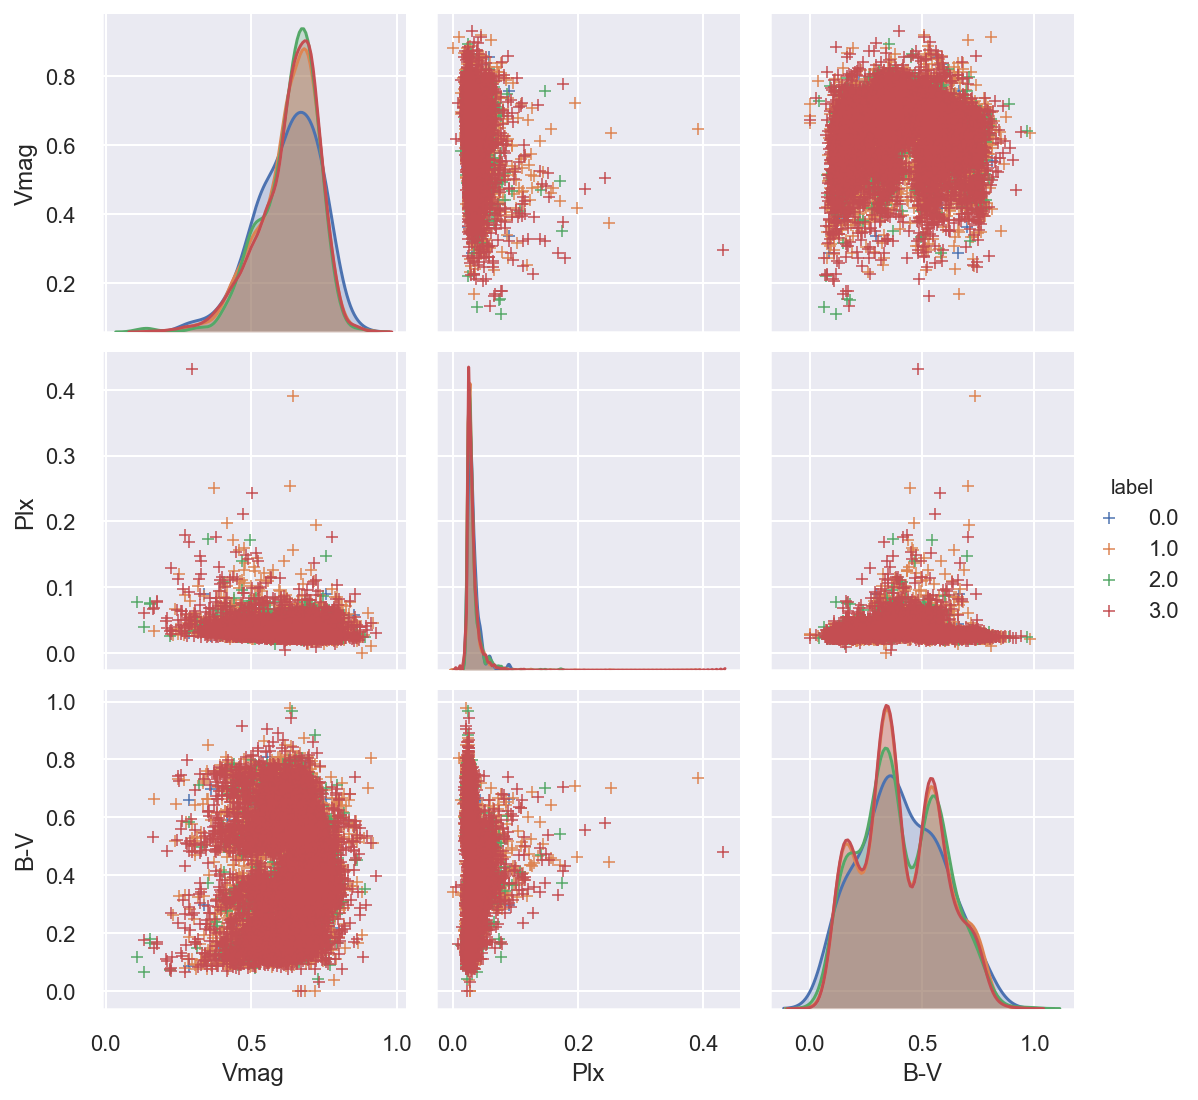

In [63]:
# Visualize result

df = pd.DataFrame(Xs, columns=["Vmag", "Plx", "B-V"])
df["label"] = data_train["label"]
g = sns.pairplot(df, hue="label", markers="+")

- It's evident that $MinMaxScaler$ doesn't provide the desired uniform distribution as several outliers still exists in the data, particularly the $P_{lx}$ feature 

- A particularly useful transformation for obtaining uniformly distributied data is the $QuantileTransformer$ 

In [64]:
# Using the Quantile Transformer 

quantile_scaler = QuantileTransformer(output_distribution="uniform")
Xq = quantile_scaler.fit_transform(X)

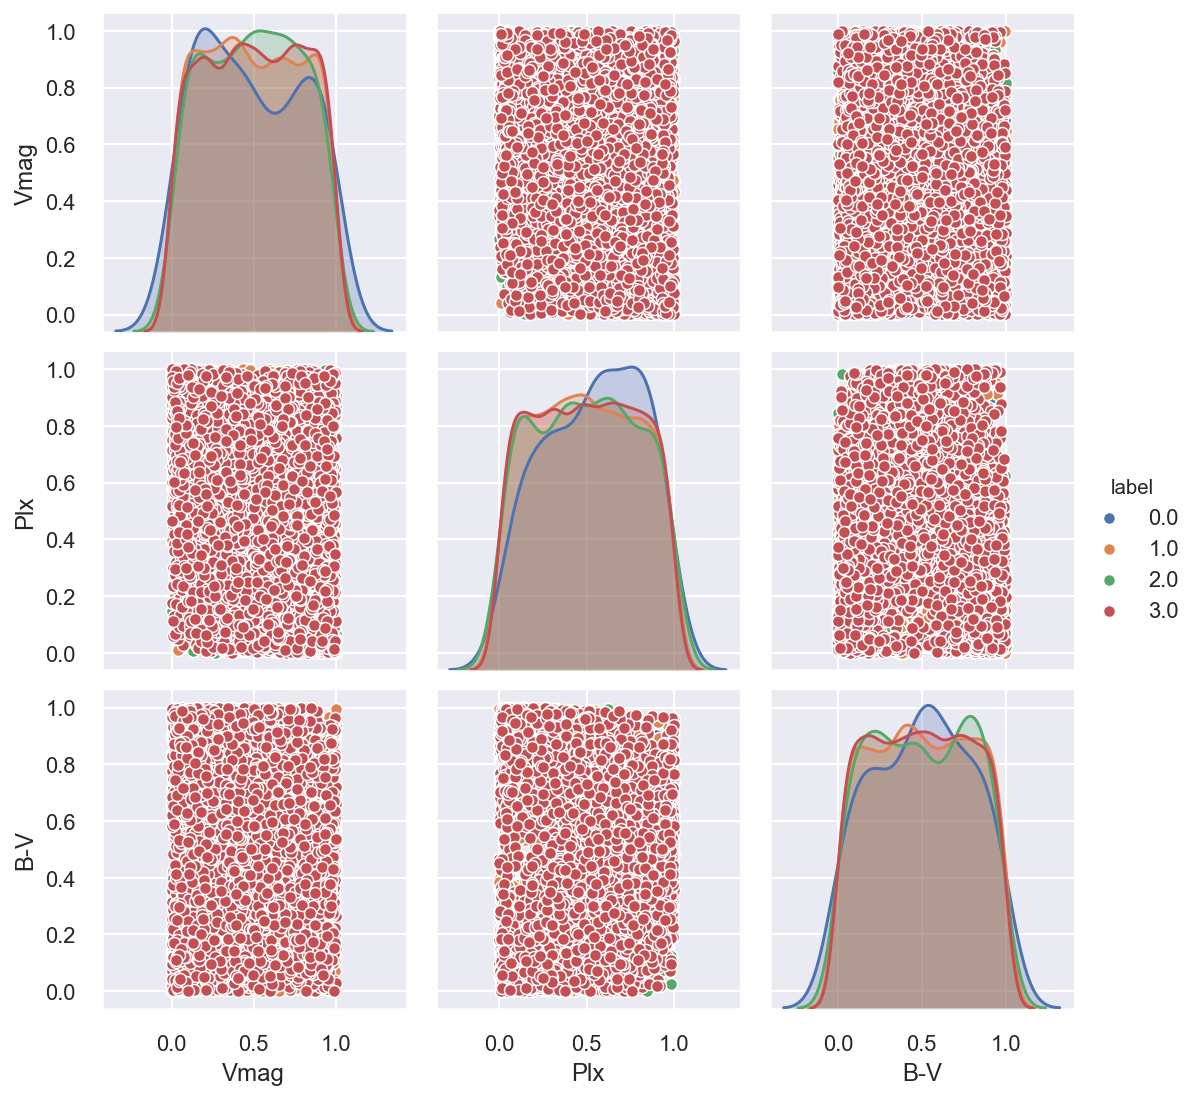

In [65]:
# Visualize result

df = pd.DataFrame(Xq, columns=["Vmag", "Plx", "B-V"])
df["label"] = data_train["label"]
g = sns.pairplot(df, hue="label")

- Now, based on the pairplot above, it is evident that the data appears uniformly distributed with less skew and would be more suitable for training.

#### 3D Visualization of the Feature Space

- Right after transformation, It will be useful to visualize the data in the 3D feature space to have a sense of how sparse or dense the data is distributed. 

- A function to implement this has been written below

In [66]:
def plot_3D(X, y, elevation, azimth):
    
    def plotter(elev=elevation, azim=azimth):
        
        font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 16}
        fig = plt.figure(figsize=(14, 8))
        ax = plt.axes(projection='3d')
        p = ax.scatter(*X.T, c=y, cmap="jet")
        ax.view_init(elev, azim)
        ax.set_xlabel('$V_{mag}$', fontdict=font, labelpad=10)
        ax.set_ylabel('$P_{lx}$', fontdict=font, labelpad=10)
        ax.set_zlabel('$B-V$', fontdict=font, labelpad=10)
        fig.colorbar(p)
        plt.show(block=False)
        
    return plotter

#### Split Data Into Train and Test sets

- Before calling the $plot\_3D$ function, the I will split the data into training and test sets to visualize them seperately.

- As a rule of thumb, the $QuantileTransformer$ will be fit on the training set and not the entire data since the test set is supposed to act as fresh unseen data. 

In [67]:

X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2, random_state=9)

quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

#### 3D Training Plot  

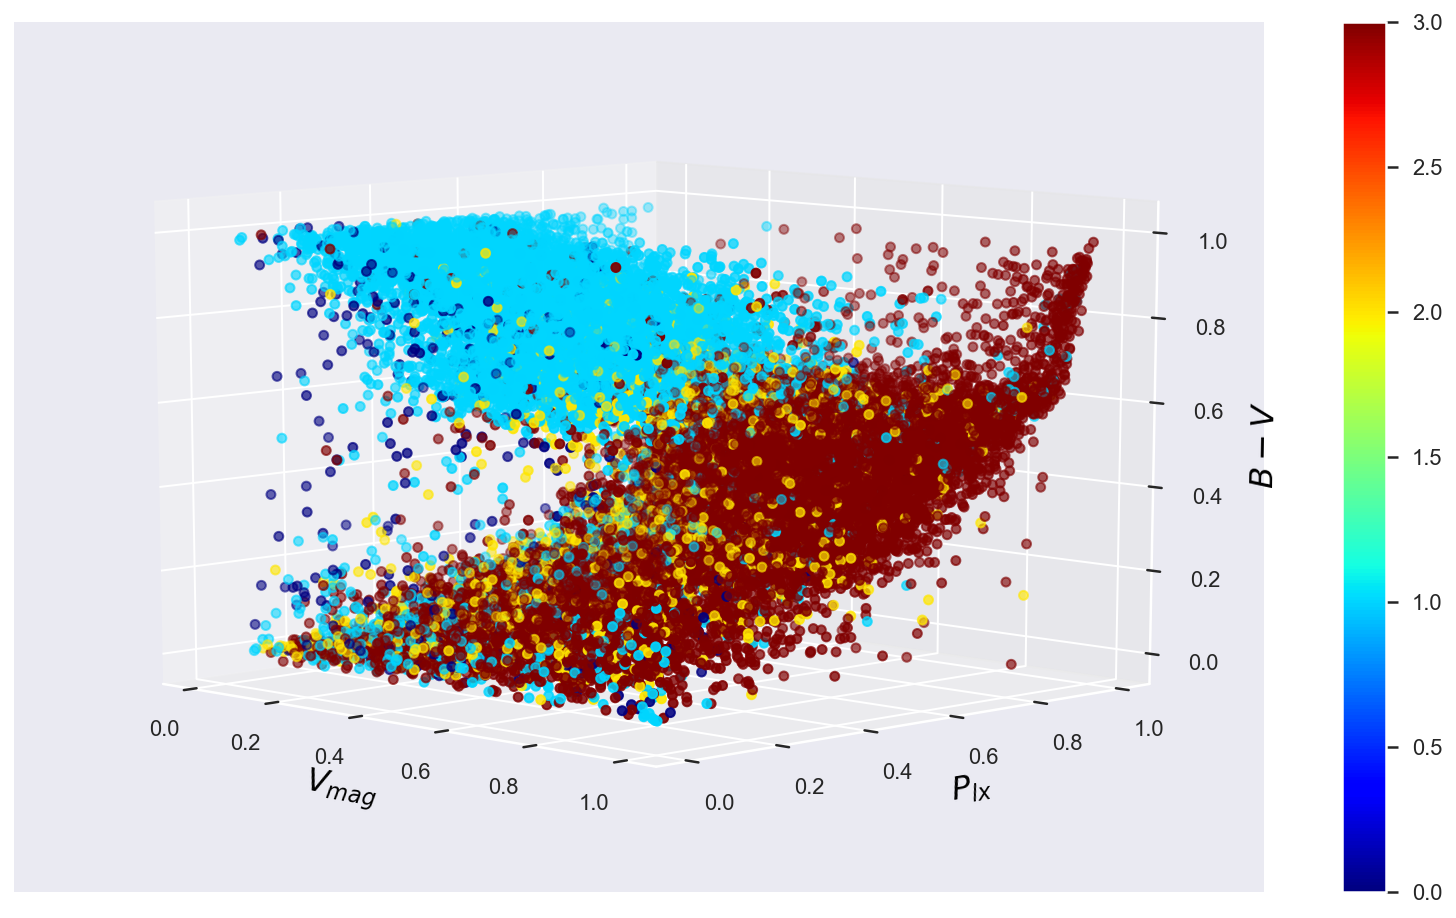

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

In [68]:
interact(plot_3D(X_train, y_train, elevation=10, azimth=-45))

#### 3D Test Plot  

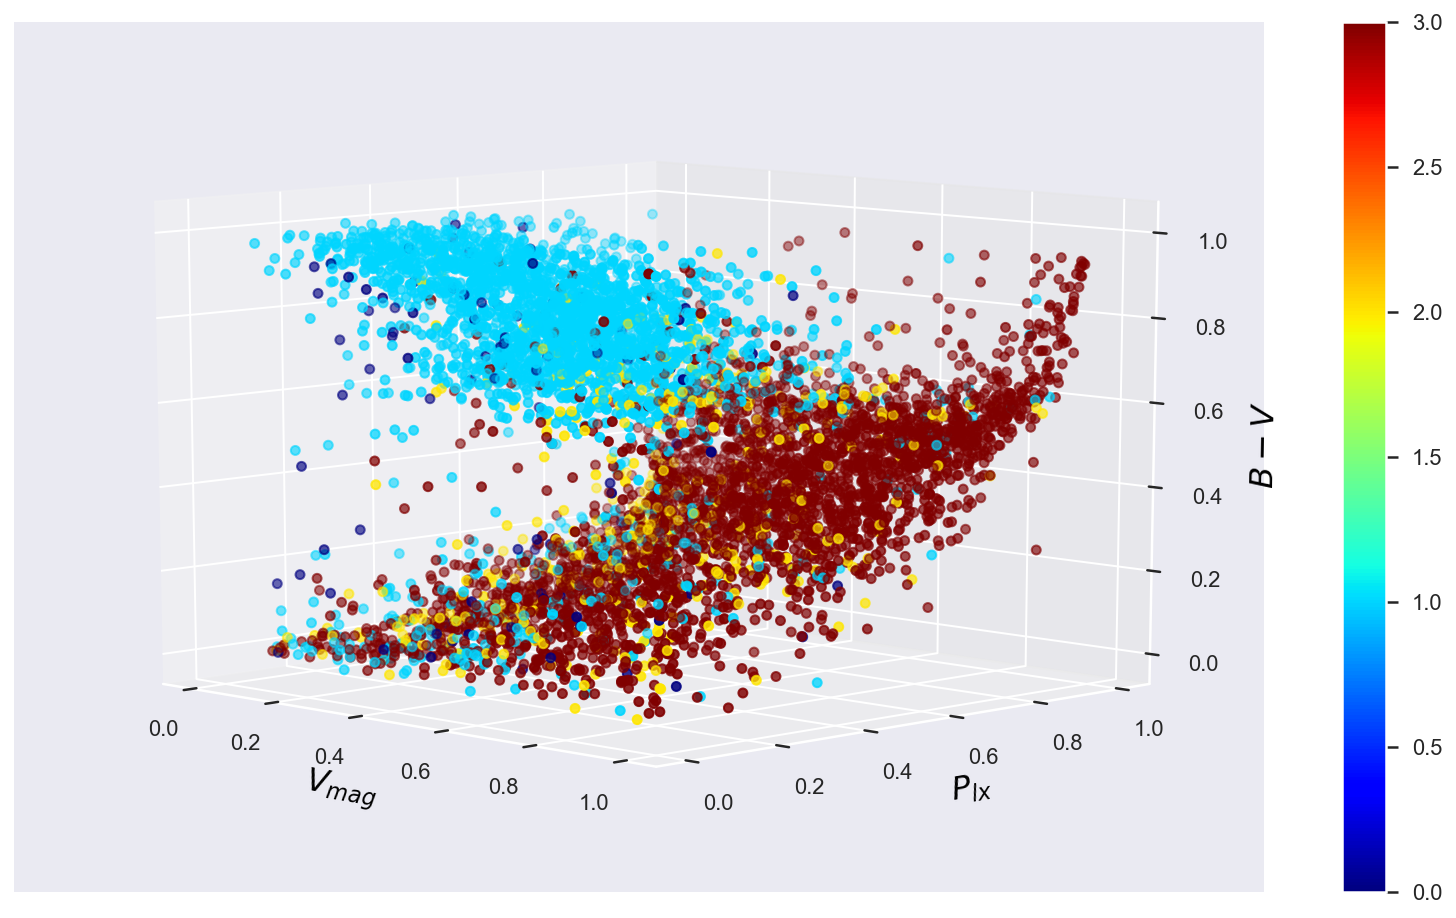

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

In [69]:
interact(plot_3D(X_test, y_test, elevation=10, azimth=-45))

- The above $3D$ plots indicate that the after splitting the data into Test and Training sets, the test set is representative of the training set and there appears to be a uniform distribution of the data along all feature dimensions

## Building The Network

- Since there is unfortunately no theoretical formulasim to determine the right number of layers or the right size for each layer. 

- As a rule, I will start with a base (naive) model with relatively few layers and parameters, which will be evaluated/tuned on a validation set to prevent information leaks.

- The validation set is chosen by simply holding-out a fold of the traning data. 

- After evaluation, the width and depth of the network will be adjusted until I observe diminishing returns with regard to validation loss.

In [70]:
model = models.Sequential()

#### Model Definition

- The architecture for this naive model is;

    - The first layer takes in as input, the three features in the $3$-$dim$ feature space. 
    - Two intermediate (hidden) layers with 2 hidden units each.
    - A final (third) layer that will output predictions regarding luminousity classes
    - The hidden layers will use $RELU$ as their activation function, permiting the activation of only a certain number of neurons from previous layers. 
    - Since this is a classification problem, the final layer will use a $sigmoid$ activation so as to output a probability. 

In [71]:
model.add(layers.Dense(2, activation="relu", input_shape=(3,)))
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#### Compiling the Model

- For the compiler, the optimizer of choice is $rmsprop$ and the loss function is used is $binary$_$crossentropy$ since we're dealing with a model that outputs probablities. As a rule, during training, the $accuracy$ metric will be monitored

In [72]:
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=["accuracy"])

#### Validation Protocol

- Since the data is sufficiently large, I will employ the $simple$ $hold$-$out$ validation protocol where I reserve a portion of the training set as the validation set.

- To do this, the test-train split function will be used. 

In [73]:
partial_X_train, X_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=0)

#### Training the Model

In [74]:
histo = model.fit(partial_X_train, partial_y_train, epochs=200, batch_size=512, validation_data=(X_val, y_val), verbose=False)

#### Plotting The Training and Validation Loss and Accuracy

Text(0.5, 0, 'Epochs')

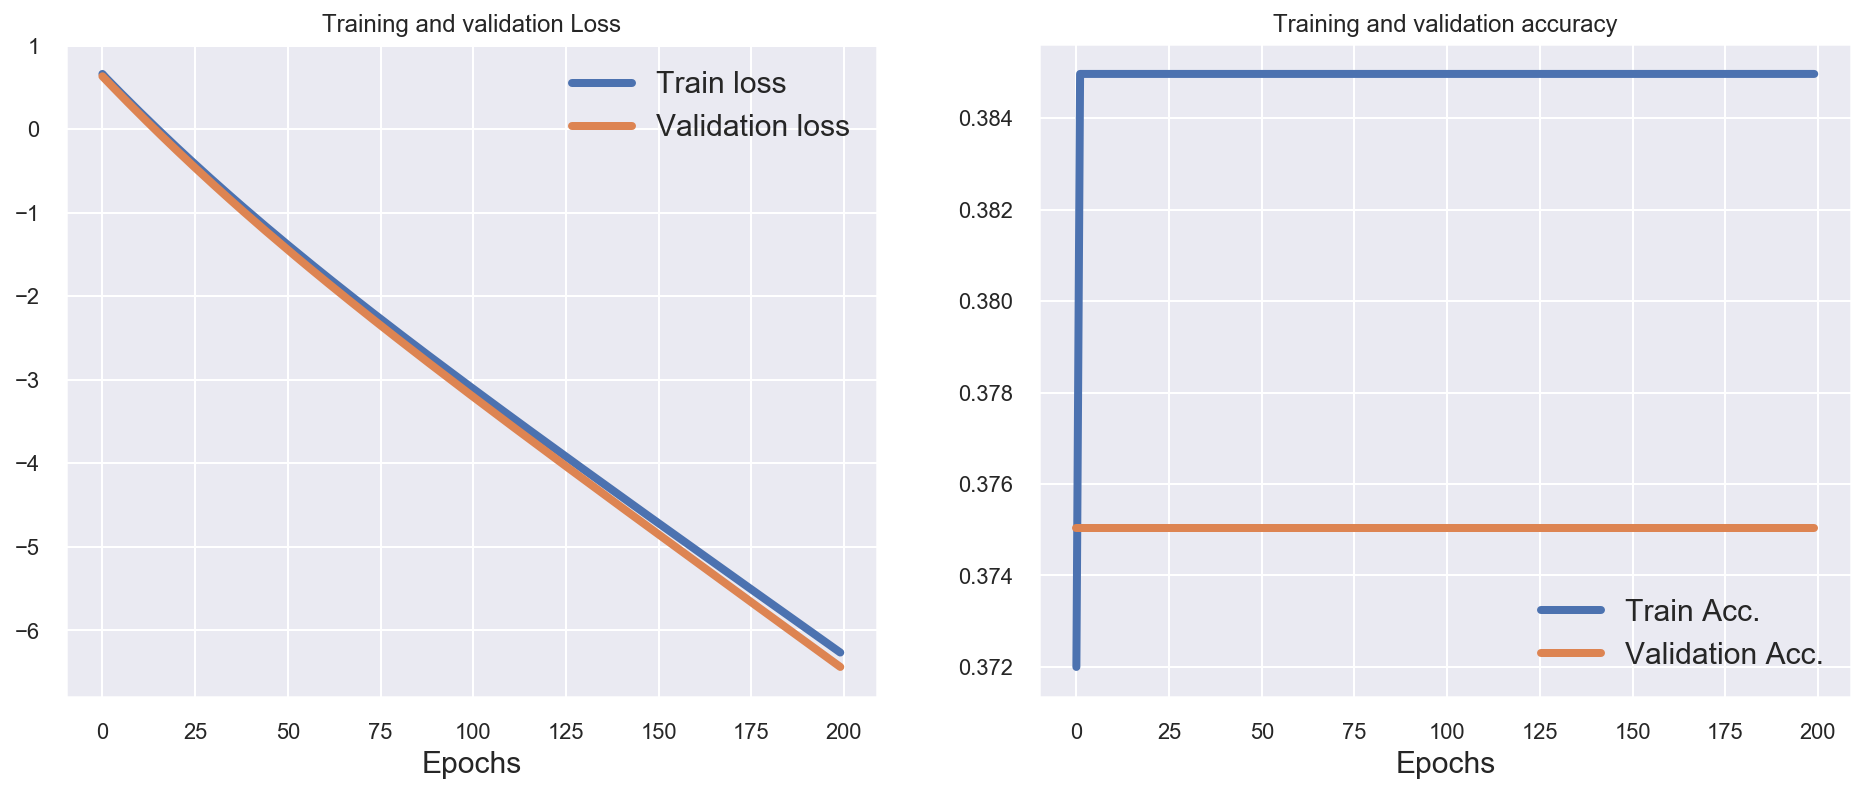

In [75]:
history = histo.history

fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax.set_title('Training and validation Loss')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_title('Training and validation accuracy')
ax.set_xlabel('Epochs', size=15)

#### Comments

- From the $Accuracy$ and $Loss$ plots shown above, it is seen that the accuracy reached by this naive model is ~$40$$%$. It can also be seen that after about $10$ $epochs$, the network begins to overfit. 

- These observations beg the question; "$Why$ $does$ $the$ $model$ $perform$ $so$ $poorly$ ?"

#### Investigation Of The Preprocessed Luminousity Classes

- To find out why the model has a remarkably poor performance, we will need to find out how many unique $Luminousity$ $Classes$ there are in the preprocessed data

In [76]:
data_train["Luminousity Class"].nunique()

4

- The investingation of the preprocessed data shows that there are $4$ different classes to be predicted. 

- Therefore, this naive model was built to classify stellar observations into one of $4$ $Luminousity$ $Classes$. Because we have many classes, and because each data point can only be classified into one category, this problem is an instance of $single$-$label$ $multiclass$ $classification$.

- The previous statement implies that the number of output classes (dimensionality of the output layer) should be $4$ not $1$, implying that the the network should end with a dense layer of size $4$. So that for each imput sample, the network will output a $4$-dimensional vector. 

- On the contray, the last layer of the naive model is a single-unit layer with a $sigmoid$ activation that squashes output probabilities between $0$ and $1$. This is only suitable for binary classification problems. 

#### Remedy?

- How then should an appropriate model architecture be designed?

    - The network should end with a dense layer of size $4$ as opposed to $1$. This means that each entry vector will encode a different output class probablility.
    
    - The last layer will use a $softmax$ activation, meaning the network will output a $probablility$ $distribution$ over the $4$ different output classes. Therefore, for every input observation, the sample will produce a $4$-dimensional output vector, where $output$[$i$] is the probability that the sample belongs to class $i$.
    
    - Since each layer can only access information present in the output of the previous layer in a dense network, it implies that reducing the number of neurons in a layer is equivalent to dropping some from information relevant to the classification problem. In the naive model, we have used a $2$-dimensional intermediate network layers, which may be too limited to learn $4$ different classes, thereby acting as information bottlenecks. For this reason, we'll use larger layers with $16$ units.
    
    - We will also need to categorically encode (vectorize) the $Luminousity$ $Classes$ using the $One$-$hot$ $encoder$ instead of the $Label$ $Encoder$. This is a requirement for the output layer which will output $probablility$ $distribution$ over the $4$ different output classes. The $One$-$hot$ $encoder$ is the preferred encoder because it embeds the labels as an all-zero vector with a $1$ in the place of the assigned label index. 
    
    - $Keras$ has a built in way to do this, by importing $to$_$categorical$ from the $utilities$ module in $Keras$ 
    
    - For this reconstructed architecture, the loss function that best suites the problem is the $categorical$ $cross$ $entropy$ because of it's adaptability for $single$-$label$ $multiclass$ $classification$.

#### Model Definition

In [77]:
model = models.Sequential()

model.add(layers.Dense(16, activation="relu", input_shape=(3,)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(4, activation="softmax"))

#### Comiling The Model

In [78]:
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=["accuracy"])

#### Encoding Labels 

In [79]:
y_one_hot = to_categorical(data_train["label"])

#Set aside training and testing sets
X_train, X_test, y_train_one_hot, y_test_one_hot = train_test_split(X, y_one_hot, test_size=0.2, random_state=9)

# Tranform feature vectors.
quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

#### Validation Protocol

- The same validation protocol employed in the naive model will be employed here

In [80]:
partial_X_train, X_val, partial_y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.4)

#### Training the Model

In [81]:
histo = model.fit(partial_X_train, partial_y_train_one_hot, epochs=200, batch_size=512,
                  validation_data=(X_val, y_val_one_hot), verbose=False)

#### Plotting The Training and Validation Loss and Accuracy

Text(0.5, 0, 'Epochs')

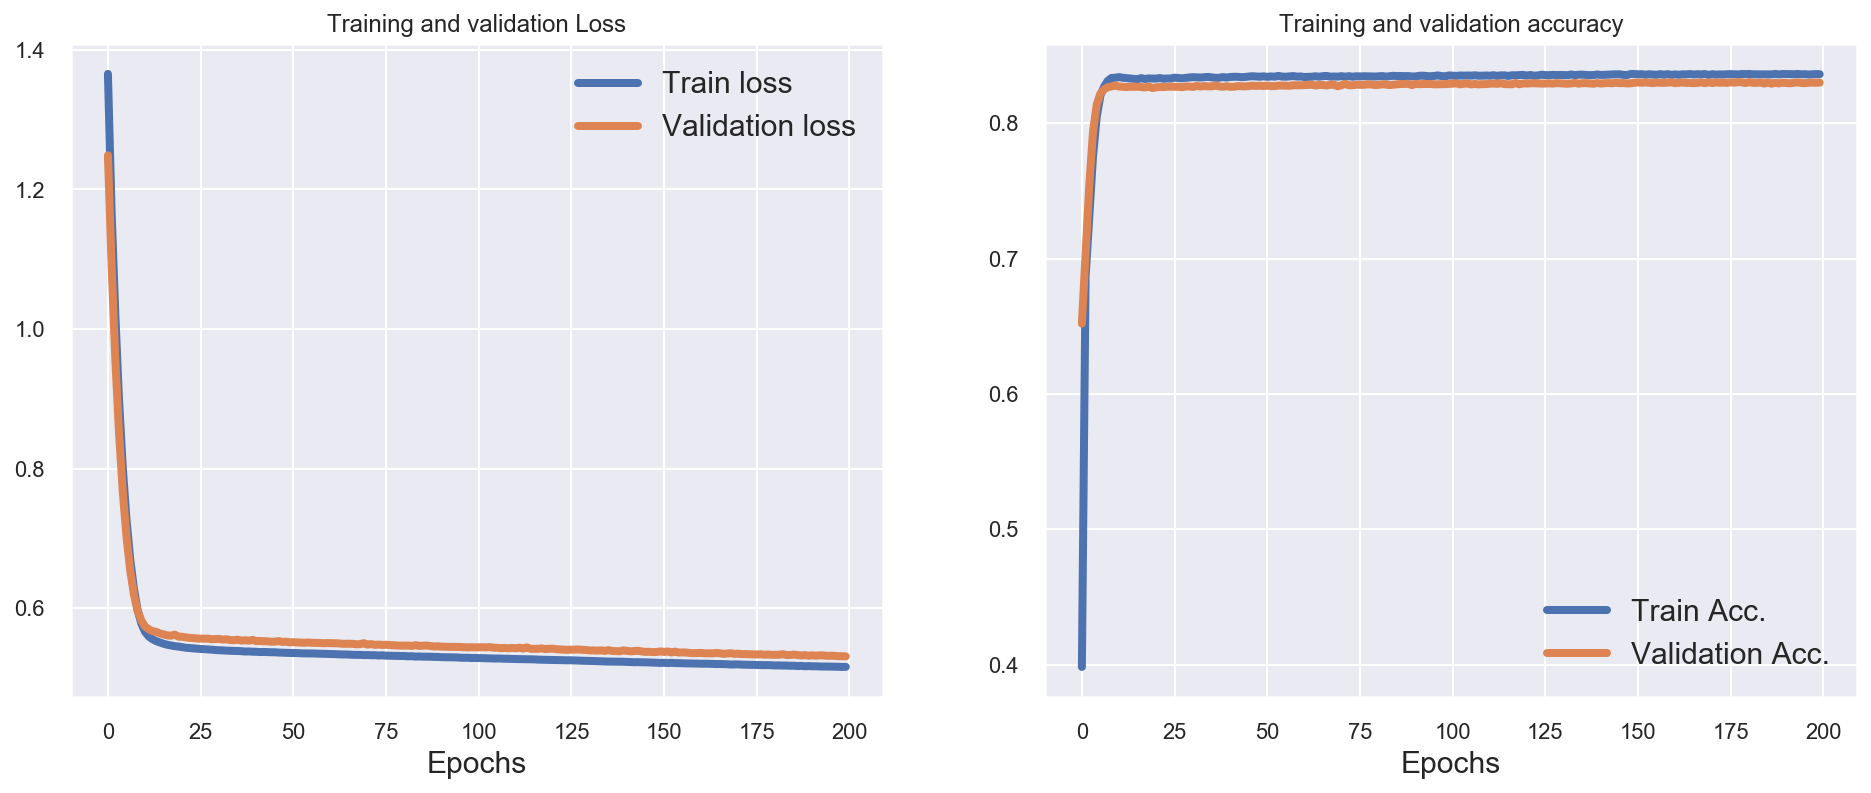

In [82]:
history = histo.history

fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax.set_title('Training and validation Loss')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_title('Training and validation accuracy')
ax.set_xlabel('Epochs', size=15)

#### Display Model Evaluation

In [83]:
results = model.evaluate(X_val, y_val_one_hot, verbose=False)
print("Model accuracy on the validation set is ~{:.2f}%".format(results[1]*100))
print("Model Loss on the validation set is ~{:.2f}".format(results[0]))

Model accuracy on the validation set is ~83.00%
Model Loss on the validation set is ~0.53


#### Comments

- We see from the $Loss$ and $Accuracy$ plots that, compared to the naive model, this retrained model performs significantly better, reaching accuracy levels of ~$83$%. This is suggestive of pretty good model. 

- To consolidate this view, let's compare this accuracy to that of a purely random classifier with a balanced binary classification problem. 

- To do this, we will shuffle the original, un-encoded, data labels and subsequently compare the shuffled labels to the original (un-shuffled, un-encoded) data labels. It is expected that such random shuffling is the result of a purely random classifier which should only reach an accuracy of ~$50$%.

- We can glean insights into the performance of the retrained model if we compare the accuracy of the retrained model to that of the purely random classifier. 

In [84]:
# Create a copy of the un-encoded y_train labels
y_train_copy = copy(y_train)

# randomly shuffle copied labels
np.random.shuffle(y_train_copy)

# compare shuffled labels to actual labels and select matching labels and assign to hits array
hits_array = np.array(y_train) == np.array(y_train_copy)

#compute accuracy
random_classifier_accuracy = float(np.sum(hits_array)) / len(y_train)

print("Accuracy of purely random classifier is ~{}%".format(np.round(random_classifier_accuracy*100)))

Accuracy of purely random classifier is ~41.0%


- We see in this case that the random classifier reaches an accuracy of ~$41$% closer to the naive model constructed initially and significantly lower than $83$%

- Therefore, when compared to a random baseline (and by extension the naive model), this retrained model seems pretty good.

#### Is This The Optimal Model?

- First, we address the problem of overfitting and underfitting;

    - The $Loss$ and $Accuracy$ plots show no significant difference in values when the $validation$ and $training$ results are compared on each metric, indicating that the model neither overfits nor undefits the data.
    
    - To consolidate this idea, we'll evaluate the model on the test-set (which the network has never seen). 

In [85]:
results = model.evaluate(X_test, y_test_one_hot, verbose=False)
print("Model accuracy on the test-set is ~{:.2f}%".format(results[1]*100))
print("Model Loss on the test-set is ~{:.2f}".format(results[0]))

Model accuracy on the test-set is ~83.54%
Model Loss on the test-set is ~0.52


- The test-set accuracy turns out to be ~$83$% which is the same the training set accuracy. In the same vein, the loss is approximately equal to that obtained for the training-set. Hence, the model neither overfits nor undefits the data. 

- Second, we address the question of whether this is the optimal architecture. Is there another combination of parameters$-$$activation$ $functions$, $loss$ $function$, $network$ $depth$, and $network$ $width$ $-$ that could yield better performance in terms of $loss$ and $accuracy$?

- Since there's unfortunatley no magical formula, we investigate this by trying the following versions;

    - Version with higher capacity
    - Version with lower capacity
    - Version with regularized weights
    - Version with custom optimizer

#### Version with higher capacity

- How does a larger network fare compared to the reference network. 

- We will train a model with the same parameters as the reference model but with more neurons ($512$) in the intermediate layer. This will significantly increase the number of learnable parameters. 

- The idea is that, a model with more parameters has more capacity for memorization and should easily learn a perfect dictionary-like mapping between observations and their targets$—$ yielding a mapping without any generalization power. 

In [86]:
higher_cap_model = models.Sequential()

higher_cap_model.add(layers.Dense(512, activation="relu", input_shape=(3,)))
higher_cap_model.add(layers.Dense(512, activation="relu"))
higher_cap_model.add(layers.Dense(4, activation="softmax"))

higher_cap_model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=["accuracy"])

higher_cap_histo = higher_cap_model.fit(partial_X_train, partial_y_train_one_hot, epochs=200, batch_size=512,
                  validation_data=(X_val, y_val_one_hot), verbose=False)

higher_cap_history = higher_cap_histo.history

fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.plot(higher_cap_history['loss'], lw=4)
plt.plot(higher_cap_history['val_loss'], lw=4)
ax.set_xlabel('Epochs', size=15)
plt.legend(['Ref. Model Train Loss. ', 'Ref. Model Validation Loss.',
            'Higher Cap. Model Train Loss. ', 'Higher Cap. Model Validation Loss.'], fontsize=15)
ax.set_title('Loss Comparison for Reference and Higher Capacity Model')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.plot(higher_cap_history['accuracy'], lw=4)
plt.plot(higher_cap_history['val_accuracy'], lw=4)
plt.legend(['Ref. Model Train Acc. ', 'Ref. Model Validation Acc.',
            'Higher Cap. Model Train Acc. ', 'Higher Cap. Model Validation Acc.'], fontsize=15)
ax.set_title('Accuracy Comparison for Reference and Higher Capacity Model')
ax.set_xlabel('Epochs', size=15)

Text(0.5, 0, 'Epochs')

#### Comments

- We see from the figures that the bigger network has a more noisy loss and accuracy values. More so, the bigger network has it's training loss steadily approaching zero while while it's validation loss appears stable. This indicates that this network with higher capacity can quickly model the training data (resulting in a low training loss), but is more susceptible it to overfitting (resulting in a relatively larger difference between the training and validation loss). Similar result is oberved for the accuracy plots. 

#### Version with lower capacity

- How does a smaller network fare compared to the reference network. 

- We will train a model with the same parameters as the reference model but with less neurons ($2$) in the intermediate layer. This will significantly reduce the number of learnable parameters. 

- The idea is that, the simplest way to prevent overfitting is to reduce the size of the model. 

Text(0.5, 0, 'Epochs')

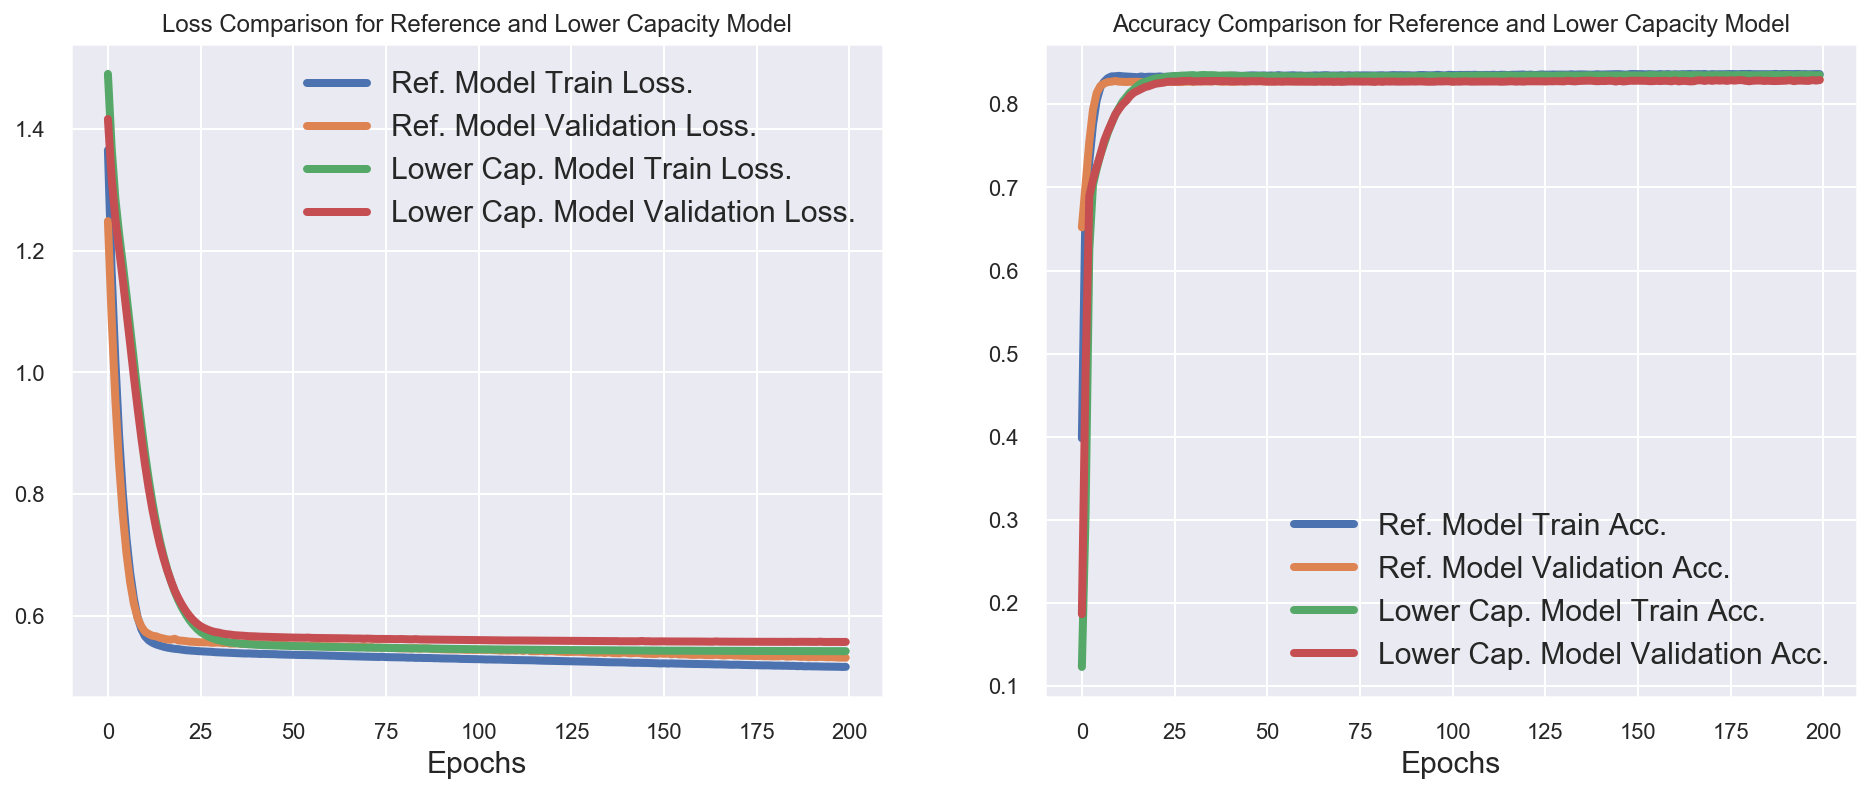

In [87]:
lower_cap_model = models.Sequential()

lower_cap_model.add(layers.Dense(2, activation="relu", input_shape=(3,)))
lower_cap_model.add(layers.Dense(2, activation="relu"))
lower_cap_model.add(layers.Dense(4, activation="softmax"))

lower_cap_model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=["accuracy"])

lower_cap_histo = lower_cap_model.fit(partial_X_train, partial_y_train_one_hot, epochs=200, batch_size=512,
                  validation_data=(X_val, y_val_one_hot), verbose=False)

lower_cap_history = lower_cap_histo.history

fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.plot(lower_cap_history['loss'], lw=4)
plt.plot(lower_cap_history['val_loss'], lw=4)
ax.set_xlabel('Epochs', size=15)
plt.legend(['Ref. Model Train Loss. ', 'Ref. Model Validation Loss.',
            'Lower Cap. Model Train Loss. ', 'Lower Cap. Model Validation Loss.'], fontsize=15)
ax.set_title('Loss Comparison for Reference and Lower Capacity Model')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.plot(lower_cap_history['accuracy'], lw=4)
plt.plot(lower_cap_history['val_accuracy'], lw=4)
plt.legend(['Ref. Model Train Acc. ', 'Ref. Model Validation Acc.',
            'Lower Cap. Model Train Acc. ', 'Lower Cap. Model Validation Acc.'], fontsize=15)
ax.set_title('Accuracy Comparison for Reference and Lower Capacity Model')
ax.set_xlabel('Epochs', size=15)

#### Comments

- We see that a smaller network has a higher loss and lower accuracy values. This indicates that the model has limited memorization resouces and struggles to learn the mapping from observations to labels, a problem of underfitting.

#### Comments on Reference Model Capacity

- Since we require a model that has just the right parameters such that it doesn't overfit or undefit, the above comparisons indicate that the reference model provides such a compromise between too much capacity and not enough capacity.

#### Version with Regularized Weights

- Another way of investigating overfitting and underfitting is to put constraints on the network complexity by forcing weights to take only small values for certain features, which makes the distribution of weight values more regular. 

- We can regularize the weights by adding a regularizer in the intermediate network layers equivalent to a cost associated with having large weights. 

- This parameter is parsed as $kernel$_$regularizer$=$regularizers$.$cost$($penalty$). We assume this $cost$ is proportional to the square of the value of the weight coefficients, so, we use the $L2$ norm of the weights.

- Therefore, in the model layers, we include $kernel$-$regularizer$=$regularizers$.$l2$($penalty$), where $penalty$=$0.01$. This means every coefficient in the weight matrix of the layer will add $0.01$$*$$weight$-$coefficient$_$value$ to the total loss of the network.

- Other parameters will remain the same.

In [88]:
reg_model = models.Sequential()

reg_model.add(layers.Dense(16,  kernel_regularizer=regularizers.l2(0.01), activation="relu", input_shape=(3,)))
reg_model.add(layers.Dense(16,  kernel_regularizer=regularizers.l2(0.01), activation="relu"))
reg_model.add(layers.Dense(4, activation="softmax"))

reg_model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=["accuracy"])

reg_model_histo = reg_model.fit(partial_X_train, partial_y_train_one_hot, epochs=200, batch_size=512,
                  validation_data=(X_val, y_val_one_hot), verbose=False)

reg_model_history = reg_model_histo.history

fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.plot(reg_model_history['loss'], lw=4)
plt.plot(reg_model_history['val_loss'], lw=4)
ax.set_xlabel('Epochs', size=15)
plt.legend(['Ref. Model Train Loss. ', 'Ref. Model Validation Loss.',
            'Regularized Model Train Loss. ', 'Regularized Model Validation Loss.'], fontsize=15)
ax.set_title('Loss Comparison for Reference and Regularized Model')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.plot(reg_model_history['accuracy'], lw=4)
plt.plot(reg_model_history['val_accuracy'], lw=4)
plt.legend(['Ref. Model Train Acc. ', 'Ref. Model Validation Acc.',
            'Regularized Model Train Acc. ', 'Regularized Model Validation Acc.'], fontsize=15)
ax.set_title('Accuracy Comparison for Reference and Regularized Model')
ax.set_xlabel('Epochs', size=15)

Text(0.5, 0, 'Epochs')

#### Comments

- The figure above shows that the $L2$ regularization penalty has no significant asides from being more resistant to overfitting, since the training and validation losses have a relatively smaller difference compared to the reference model.

#### Version with custom optimizer

- I considered the possibility that the model got stuck or converged too quickly to suboptimal solution, a phenomenon influenced by the the $Learning$ $rate$.

- To find the optimal configuration, I adjusted the $Learning$ $rate$ used by the $RMSprop$ optimizer.

- Configuring the parameter of the optimizer, would require passing an $optimizer$ class instance as the optimizer argument with the specified $Learning$ $rate$.

- The default $Learning$ $rate$ used by the $RMSprop$ optimizer is $0.001$, therefore, the reference model will be compared to a versions with larger ($0.01$) and smaller ($0.0001$) $Learning$ $rates$.  

Text(0.5, 0, 'Epochs')

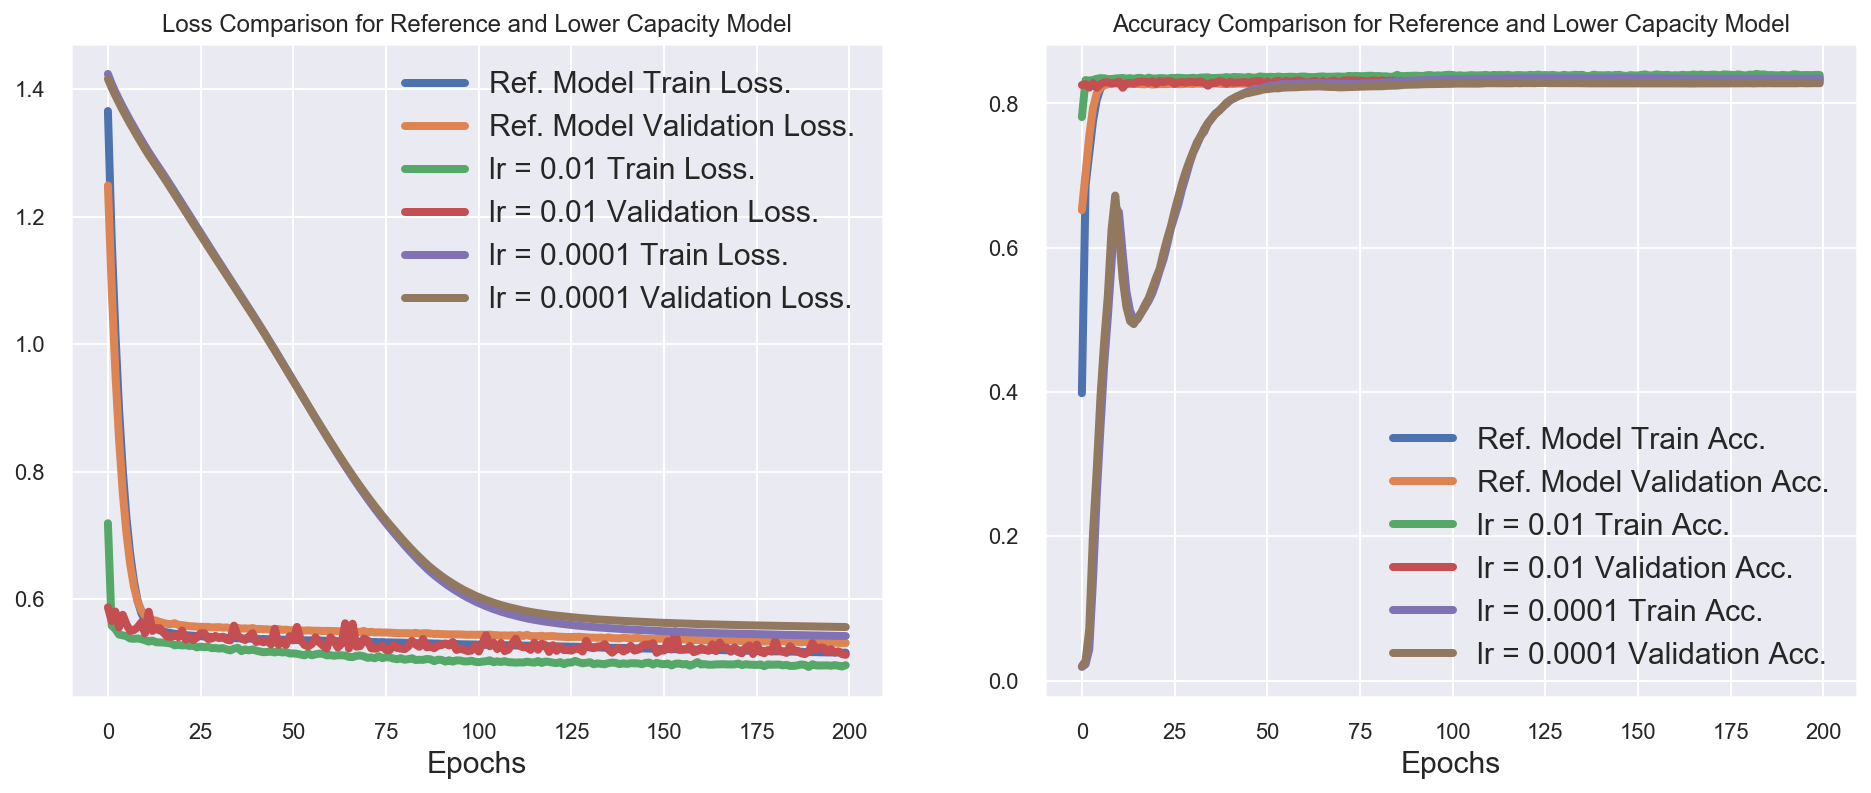

In [89]:
lr_p01_model = models.Sequential()

lr_p01_model.add(layers.Dense(16, activation="relu", input_shape=(3,)))
lr_p01_model.add(layers.Dense(16, activation="relu"))
lr_p01_model.add(layers.Dense(4, activation="softmax"))

lr_p01_model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss='categorical_crossentropy', metrics=["accuracy"])

lr_p01_model_histo = lr_p01_model.fit(partial_X_train, partial_y_train_one_hot, epochs=200, batch_size=512,
                  validation_data=(X_val, y_val_one_hot), verbose=False)

lr_p01_model_history = lr_p01_model_histo.history


lr_p0001_model = models.Sequential()

lr_p0001_model.add(layers.Dense(16, activation="relu", input_shape=(3,)))
lr_p0001_model.add(layers.Dense(16, activation="relu"))
lr_p0001_model.add(layers.Dense(4, activation="softmax"))

lr_p0001_model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

lr_p0001_model_histo = lr_p0001_model.fit(partial_X_train, partial_y_train_one_hot, epochs=200, batch_size=512,
                  validation_data=(X_val, y_val_one_hot), verbose=False)

lr_p0001_model_history = lr_p0001_model_histo.history


fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.plot(lr_p01_model_history['loss'], lw=4)
plt.plot(lr_p01_model_history['val_loss'], lw=4)
plt.plot(lr_p0001_model_history['loss'], lw=4)
plt.plot(lr_p0001_model_history['val_loss'], lw=4)
ax.set_xlabel('Epochs', size=15)
plt.legend(['Ref. Model Train Loss. ', 'Ref. Model Validation Loss.',
            'lr = 0.01 Train Loss. ', 'lr = 0.01 Validation Loss.',
           'lr = 0.0001 Train Loss. ', 'lr = 0.0001 Validation Loss.'], fontsize=15)
ax.set_title('Loss Comparison for Reference and Lower Capacity Model')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.plot(lr_p01_model_history['accuracy'], lw=4)
plt.plot(lr_p01_model_history['val_accuracy'], lw=4)
plt.plot(lr_p0001_model_history['accuracy'], lw=4)
plt.plot(lr_p0001_model_history['val_accuracy'], lw=4)
plt.legend(['Ref. Model Train Acc. ', 'Ref. Model Validation Acc.',
            'lr = 0.01 Train Acc. ', 'lr = 0.01 Validation Acc.',
           'lr = 0.0001 Train Acc. ', 'lr = 0.0001 Validation Acc.'], fontsize=15)
ax.set_title('Accuracy Comparison for Reference and Lower Capacity Model')
ax.set_xlabel('Epochs', size=15)

#### Comments

- The figures above show that increasing or decreasing the ($Learning$ $rate$) does not significantly improve model performance. 

#### Set-up Predictability

- In summary, we see that the model versions considered do not provide considerable improvements to the reference model. More so, versions with higher and lower capacity either creates information bottlenecks, resulting in an obsolute accuracy drop of ~$40$%, or learns misleading or irrelevant patterns found in the training data. In addition, the model is seen to be pretty good  when compared to the random (naive) baseline model. Therefore, the reference model appears to be the optimal model for prediction and will be used to asnwer the exam question with all it's paramters and architecture. 

#### Predict Exam Data

- Now, I will run the reference model to predict the encoded $Luminousity$ $Classes$ of the exam question data

- Before that is done, the features of the exam data have to be transformed using the $QuantileTransformer$ fitted to the raw training data

- Subsequently, I will use the $np.argmax$ method on the predicted $one$-$hot$-$encoded$ labels to extract the $Lunminousity$ $Class$ on the $0 - 7$ scale, and then inverse_transform to extract the $Lunminousity$ $Class$ on the $I - VII$ scale

- This prediction will be saved to the exam_data DataFrame as $LuminousityClass\_Q2$, where $Q2$ represents $Question 2$

In [90]:
X_exam = quantile_scaler.transform(exam_data)

In [91]:
y_exam = model.predict(X_exam)

y_exam = np.argmax(y_exam, axis=1)

y_exam = le.inverse_transform(y_exam)

In [92]:
exam_data["LuminousityClass_Q2"] = y_exam

## Absolute Magnitude

In [93]:
data_train["Amag"] = data_train["Vmag"] + 5.0*(np.log10(data_train["Plx"]) + 1)

C:\Users\adeoy\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\adeoy\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


- The above formula throws a $RuntimeWarning:$ $divide$ $by$ $zero$ $encountered$ $in$ $log10$ 

- This is because $log_{10}$$(x)$ is undefined for $x$ $≤$ $0$. 

- This implies that there are observations with $P_{lx}$ of zero or negative

- To remedy this, we will take the absolute value of $P_{lx}$ and drop observations where $P_{lx} = 0$ 

In [94]:
data_train = data_train[data_train["Plx"] != 0]

data_train["Amag"] = data_train["Vmag"] + 5.0*(np.log10(abs(data_train["Plx"])) + 1)

#### Obtain $A_{mag}$ For Exam Data

- In the same vein, we will drop observations in the exam data where $P_{lx} = 0$ 

In [95]:
exam_data[exam_data["Plx"] == 0].shape

(0, 4)

- There are no observations in the exam data observations where $P_{lx} = 0$. Therefore there is no need to drop any rows

- Obtain $A_{mag}$ using absolute value of $P_{lx}$

In [96]:
exam_data["Amag"] = exam_data["Vmag"] + 5.0*(np.log10(abs(exam_data["Plx"])) + 1)

#### Select Features and Identify Label

In [97]:
X = data_train[["B-V", "Amag"]]
y = data_train["label"]

- Do the same for exam data

In [98]:
X_exam = exam_data[["B-V", "Amag"]]

#### Exploratory Analysis

In [99]:
plt.scatter(X["B-V"].to_numpy().T, X["Amag"].to_numpy().T, c=y.to_numpy(), cmap="viridis")
plt.xlabel('$B-V$')
plt.colorbar()
plt.ylabel('$A_{mag}$')

Text(0, 0.5, '$A_{mag}$')

- The exploratory analysis shown above already indicates that the features require some data preprocessing or transformations because the raw features exists on different scales. 

- This tempts one to apply preprocessing technqiues like the $MinMaxScaler$

Text(0, 0.5, '$A_{mag}$')

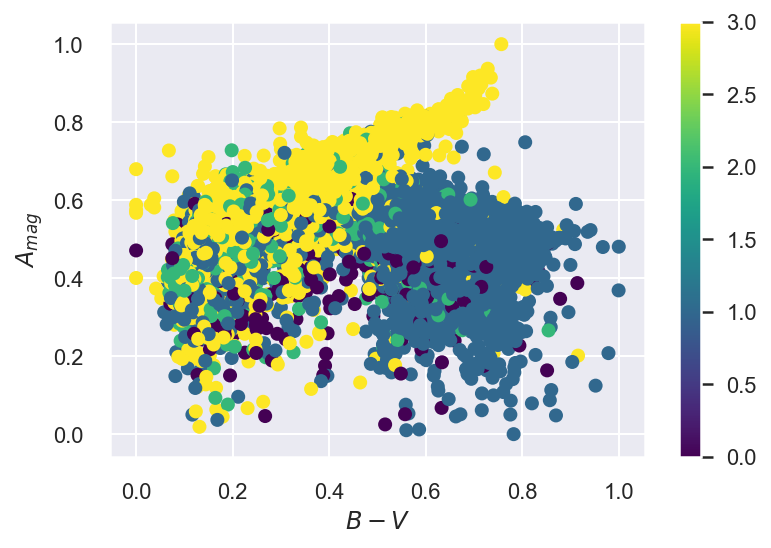

In [100]:
scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)

plt.scatter(Xs[:, 0].T, Xs[:, 1].T, c=y.to_numpy(), cmap="viridis")
plt.xlabel('$B-V$')
plt.colorbar()
plt.ylabel('$A_{mag}$')

- Again, it is evident that $MinMaxScaler$ doesn't provide the desired uniform distribution as several outliers still exists in the data.

- A particularly useful transformation for obtaining uniformly distributied data is the $QuantileTransformer$ 

Text(0, 0.5, '$A_{mag}$')

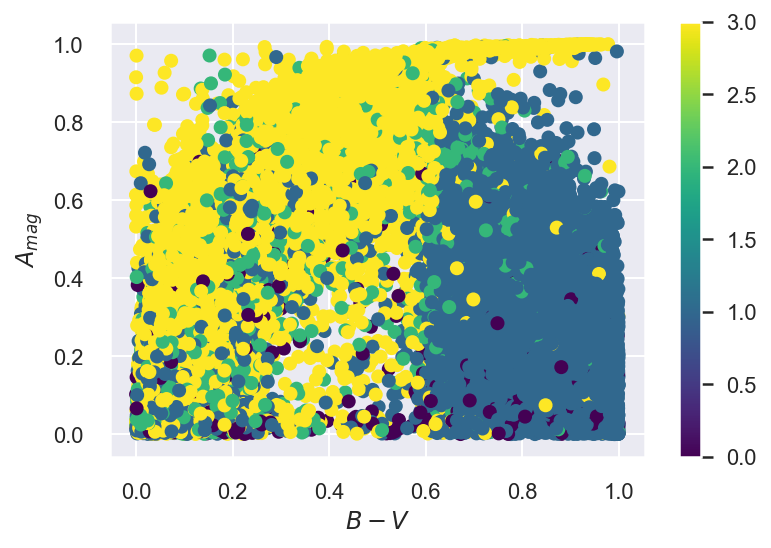

In [101]:
quantile_scaler = QuantileTransformer(output_distribution="uniform")
Xq = quantile_scaler.fit_transform(X)

plt.scatter(Xq[:, 0].T, Xq[:, 1].T, c=y.to_numpy(), cmap="viridis")
plt.xlabel('$B-V$')
plt.colorbar()
plt.ylabel('$A_{mag}$')

- Now, based on the 2D plot above, it is evident that the data appears uniformly distributed with less skew and would be more suitable for training.

#### Model Definition

- The same model architecture employed for for the earlier problem will be used here since it has been proved to be the optimal model for this problem. 

In [102]:
model = models.Sequential()

model.add(layers.Dense(16, activation="relu", input_shape=(2,)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(4, activation="softmax"))

#### Comiling The Model

In [103]:
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=["accuracy"])

#### Encoding Labels

In [104]:
y_one_hot = to_categorical(data_train["label"])

#Set aside training and testing sets
X_train, X_test, y_train_one_hot, y_test_one_hot = train_test_split(X, y_one_hot, test_size=0.2, random_state=9)

# Tranform feature vectors.
quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

#### Validation Protocol

- The same validation protocol employed in the naive model will be employed here

In [105]:
partial_X_train, X_val, partial_y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.4)

#### Training the Model

In [106]:
histo = model.fit(partial_X_train, partial_y_train_one_hot, epochs=200, batch_size=512,
                  validation_data=(X_val, y_val_one_hot), verbose=False)

#### Plotting The Training and Validation Loss and Accuracy

Text(0.5, 0, 'Epochs')

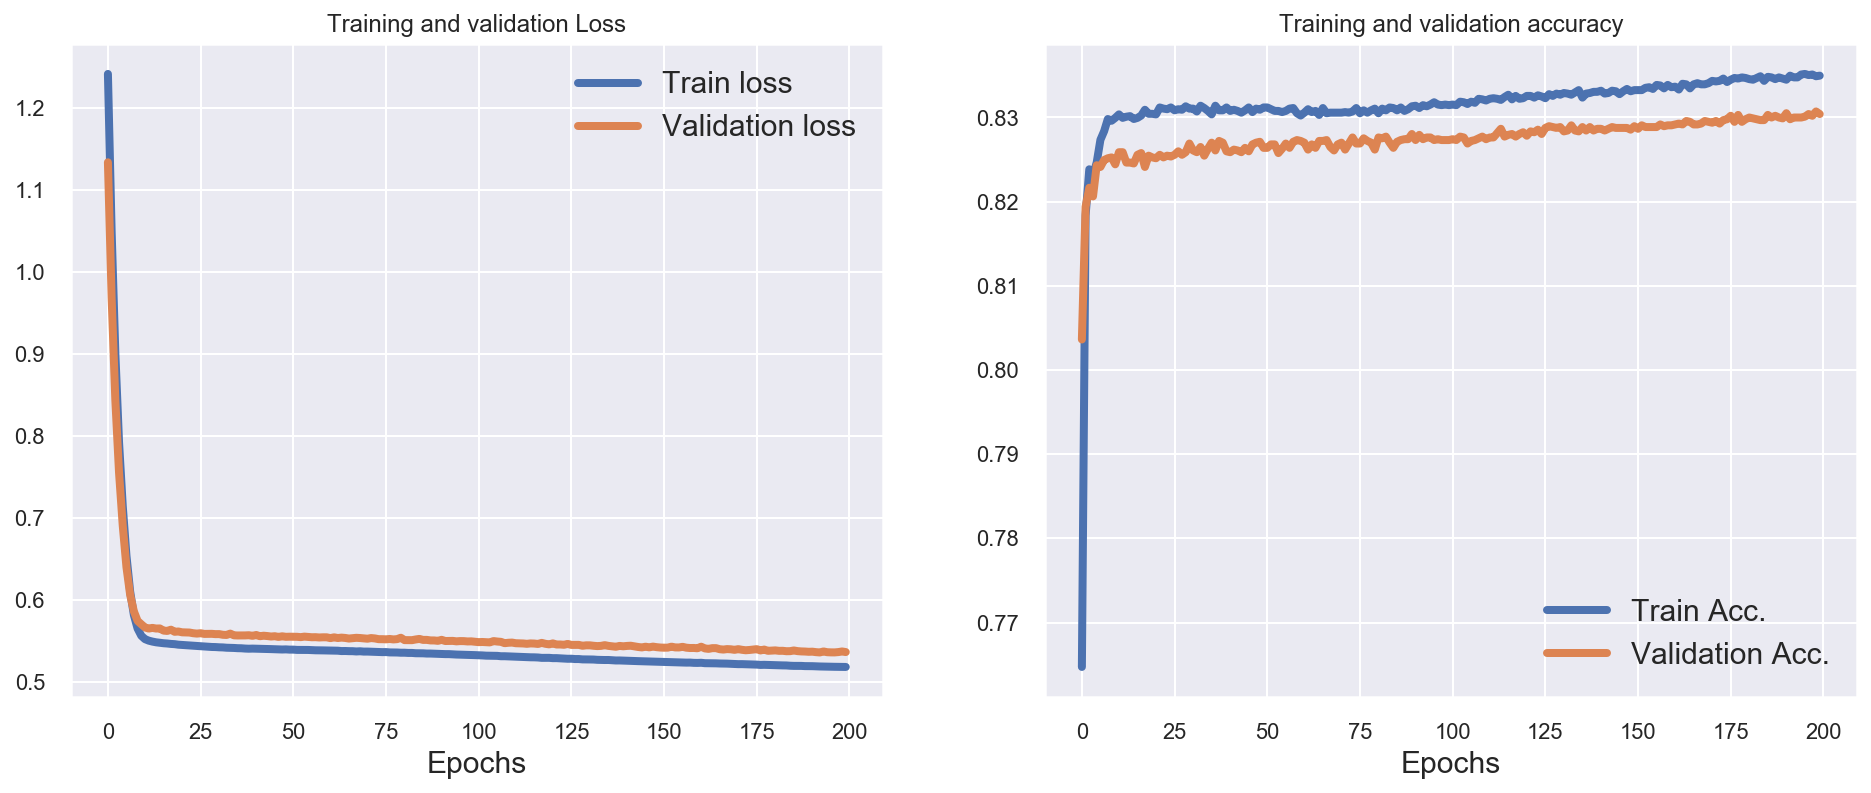

In [107]:
history = histo.history

fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax.set_title('Training and validation Loss')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_title('Training and validation accuracy')
ax.set_xlabel('Epochs', size=15)

#### Display Model Evaluation

In [108]:
results = model.evaluate(X_val, y_val_one_hot, verbose=False)
print("Model accuracy on the validation set is ~{:.2f}%".format(results[1]*100))
print("Model Loss on the validation set is ~{:.2f}".format(results[0]))

Model accuracy on the validation set is ~83.04%
Model Loss on the validation set is ~0.54


#### Comments

- We see from the $Loss$ and $Accuracy$ plots that, compared to the naive model, this model performs significantly better, reaching accuracy levels of ~$83$%. This is suggestive of pretty good model. 

- To consolidate this view, we again compare this accuracy to that of a purely random classifier with a balanced binary classification problem. 

- To do this, we will shuffle the original, un-encoded, data labels and subsequently compare the shuffled labels to the original (un-shuffled, un-encoded) data labels. It is expected that such random shuffling is the result of a purely random classifier which should only reach an accuracy of ~$50$%.

- We can glean insights into the performance of the retrained model if we compare the accuracy of the retrained model to that of the purely random classifier. 

In [109]:
# Create a copy of the un-encoded y_train labels
y_train_copy = copy(y_train)

# randomly shuffle copied labels
np.random.shuffle(y_train_copy)

# compare shuffled labels to actual labels and select matching labels and assign to hits array
hits_array = np.array(y_train) == np.array(y_train_copy)

#compute accuracy
random_classifier_accuracy = float(np.sum(hits_array)) / len(y_train)

print("Accuracy of purely random classifier is ~{}%".format(np.round(random_classifier_accuracy*100)))

Accuracy of purely random classifier is ~41.0%


- We see again case that the random classifier reaches an accuracy of ~$41$% closer to the naive model constructed initially and significantly lower than $83$%

- Therefore, when compared to a random baseline (and by extension the naive model), this model seems pretty good.

#### Is This The Optimal Model?

- In addressing the problem of overfitting and underfitting, the $Loss$ and $Accuracy$ plots show no significant difference in values when the $validation$ and $training$ results are compared on each metric, indicating that the model neither overfits nor undefits the data.
    
- To consolidate this idea, we'll evaluate the model on the test-set (which the network has never seen). 

In [110]:
results = model.evaluate(X_test, y_test_one_hot, verbose=False)
print("Model accuracy on the test-set is ~{:.2f}%".format(results[1]*100))
print("Model Loss on the test-set is ~{:.2f}".format(results[0]))

Model accuracy on the test-set is ~83.81%
Model Loss on the test-set is ~0.52


- The test-set accuracy turns out to be ~$83$% which is the same as the training set accuracy. In the same vein, the loss is approximately equal to that obtained for the training-set. Hence, the model neither overfits nor undefits the data.

#### Predict Exam Data

- Now, we will run the model to predict the encoded $Luminousity$ $Classes$ of the exam question data following the same protocol employed in the first part of this question.

- This prediction will be saved to the exam_data DataFrame as $LuminousityClass\_Q2b$, where $Q2b$ represents $Question 2b$

In [111]:
X_exam = quantile_scaler.transform(exam_data[["B-V", "Amag"]])

In [112]:
y_exam = model.predict(X_exam)

y_exam = np.argmax(y_exam, axis=1)

y_exam = le.inverse_transform(y_exam)

In [113]:
exam_data["LuminousityClass_Q2b"] = y_exam

## Decision Boundary

- The function for the decision boundary takes in the raw training data and exam data as input variables. 

In [114]:
def plot_decision_boundary(model, to_categorical, X_train, y_train, X_exam, y_exam, percentage, ax=None, cmap='rainbow'):
    
    ax = ax or plt.gca()
    
    # Plot the training points
    #p = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=cmap,
    #           clim=(y_train.min(), y_train.max()), zorder=3, alpha=0.3, label="{}% Training Data".format(percentage))
    
    p = ax.scatter(X_exam[:, 0], X_exam[:, 1], c=y_exam, s=30, cmap=cmap,
               clim=(y_exam.min(), y_exam.max()), zorder=3, alpha=0.9, label="Exam Data")
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    
    # fit the estimator
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    
    yy = to_categorical(yy.ravel())
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    
    # Create a color plot with the results
    n_classes = 4
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    ax.set_xlabel("$B-V$")
    ax.set_ylabel("$A_{mag}$")
    plt.colorbar(p)
    ax.legend(loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=7)
    plt.show()

- Since the classifiers were trained with the transformed data, the decision boundary will be plotted with transformed features from the $Quantile$ $Transformer$ of both the training set and the exam set.

- Also, the $y_{labels}$ will again be encoded to aid boundary visualization and identification of classes.


In [115]:
lenc = LabelEncoder()
scaler = QuantileTransformer()

X_train_dec = scaler.fit_transform(data_train[["B-V", "Amag"]])
y_train_dec = lenc.fit_transform(data_train["Luminousity Class"])

X_exam_dec = scaler.transform(exam_data[["B-V", "Amag"]])
y_exam_dec = lenc.transform(exam_data["LuminousityClass_Q2b"])


- To aid visualization of the data on the decision boundary, only 10% of the training data will be plotted.

- This can be done because I have shown, with the aid of 3D-Visualizations in the first part, that splitting the training set into a subset of training and test sets yields a test set that is representative of the raw training set

In [116]:
percentage = 10
X_train_dec, X_test_dec, y_train_dec, y_test_dec = train_test_split(X_train_dec, y_train_dec, 
                                                                    test_size=percentage/100, random_state=9)

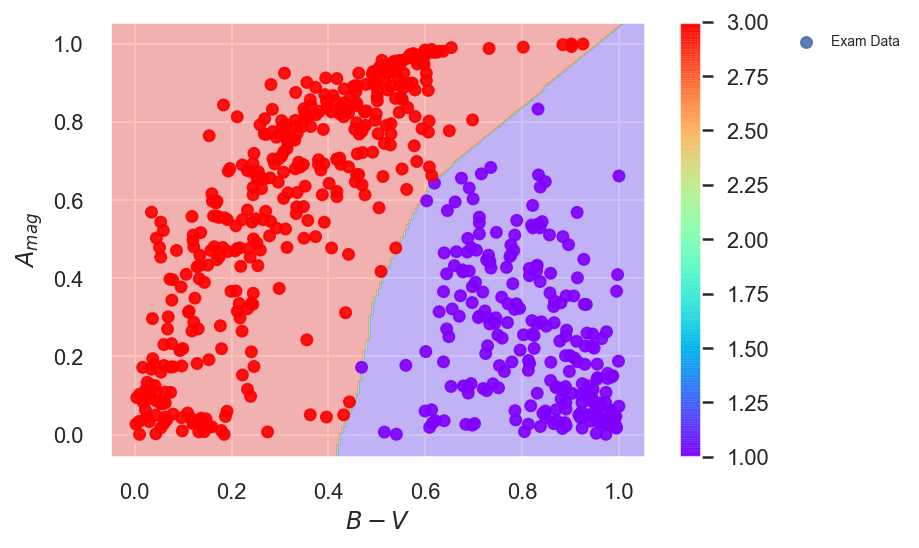

In [117]:
plot_decision_boundary(model, to_categorical, X_test_dec, y_test_dec, X_exam_dec, y_exam_dec, percentage, ax=None)


# Question Three

#### Loading the MNIST dataset in Keras

In [118]:
from keras.datasets import mnist

- Let's load the train and test-sets from the $mnist$ module in $Keras$

In [119]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#### Exploratory Analysis

- It would help to know the dimensionality and overall structure of the problem.

In [120]:
train_images.shape

(60000, 28, 28)

In [121]:
test_images.shape

(10000, 28, 28)

- Since the each image is a 2-d tensor, It is apparent that the problem at hand is to classify grayscale images into their $10$ categories ($0$ through $9$). 

- The $MNIST$ dataset has $60,000$ training images and $10,000$ test images. 

#### Model Definition

- In this model;

    - The first layer takes in as input, the $28$$X$$28$ pixels in the $28$$X$$28$-$dim$ feature space. 
    
    - Here, the network consists of two dense layers - one hidden layer, and the output layer.
    
    - Inspired by the findings in the previous question, Since each layer can only access information present in the output of the previous layer in the dense network, it implies that reducing the number of neurons in a layer is equivalent to dropping some from information relevant to the classification problem. This suggests that, since the input layer has a dimension $784$, an information bottleneck may be created if the hidden layer is chosen to have a significantly lower number of neurons. This will cause the network to be too limited to learn $10$ different classes.
    
    - Since we require a model that provides a compromise between too much capacity and not enough capacity, as described in previous questions, I have chosen a model with a single hidden layer with $784$ units.
    
    - The last layer which will output predictions is a $10$-way layer that will use a $softmax$ activation, meaning the network will output a $probablility$ $distribution$ over the $10$ different categories. Therefore, for every input observation, the sample will output a $10$ probability scores (summing up to $1$), where $output$[$i$] is the probability that the sample belongs to class $i$.
    
    - The hidden layer will use a $RELU$ activation function, permiting the activation of only a certain number of neurons from previous layers.

In [122]:
model = models.Sequential()
model.add(layers.Dense(784, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))

#### Compiling The Model

- It is quite clear from previous problems treated here that the Categorical crossentropy is the most suitbale the loss function you should use for such single-label, multiclass classification problem. It minimizes the distance between the probability distributions output by the network and the true distribution of the targets.

- For this reason, the loss function and optimizer employed here will be the same as in previous problems


In [123]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Preparing the image data

- First, we need inspect a few image examples to see what the image looks like and how the pixels are distributed.

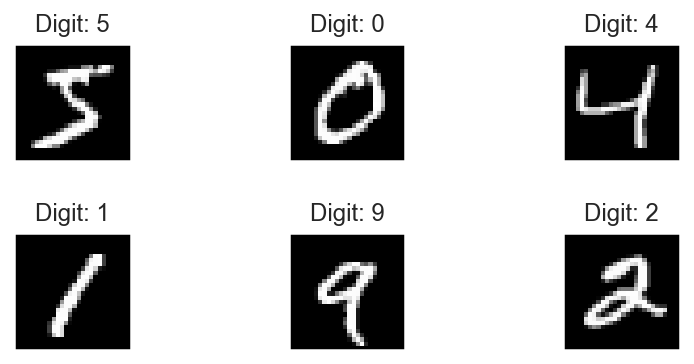

In [124]:
fig = plt.figure()

for i in range(6):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(train_images[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(train_labels [i]))
    plt.xticks([])
    plt.yticks([])


- Prior to training, the images need to be preprocessed. First, we have to unroll the $height$ $X$ $width$ ($28$ $X$ $28$) feature vectors into a $784$-dimensional feature vector for each image.

In [125]:
train_images = train_images.reshape((60000, 28*28))
test_images = test_images.reshape((10000, 28*28))

- More so, it is important to understand the distribution of these pixels. This is because the $784$ ($28$ $X$ $28$) feature vectors currently have values in the intervale $[$ $0$, $255$$]$. This could trick the network into thinking certain feature vectors are of more importance. Let's take a look at one of the pixel distribution for one of the images.

Text(0.5, 1.0, 'Pixel Value Distribution')

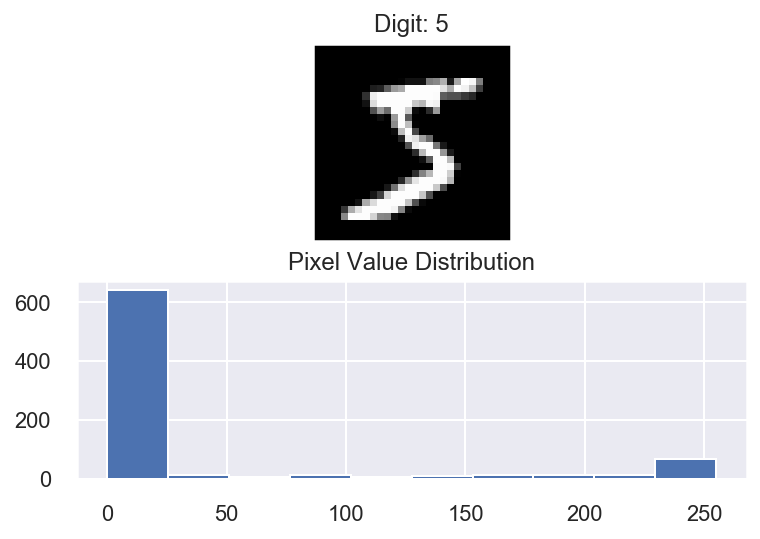

In [126]:
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(train_images[0].reshape(28, 28), cmap='gray', interpolation='none')
plt.title("Digit: {}".format(train_labels[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.hist(train_images[0].reshape(784))
plt.title("Pixel Value Distribution")

- It is seen that the background majority close to $0$ ($black$), and those close to $255$ ($white$) representing the digit are in disproportionate quantity. Which, as mentioned earlier, may trick the network. To remedy this, scale the features so that all values are normalized between $0$ and $1$ and not $[$ $0$, $255$$]$. This is achieved by dividing the feature vectors by $255$
 
- Moreso, the images are tensors of type $unit8$. This will be be converted to type $float32$

In [127]:
train_images = train_images.astype("float32")/255
test_images = test_images.astype("float32")/255

#### Preparing the labels

 - We also need to categorically encode (vectorize) the $Labels$ using the $One$-$hot$ $encoder$. This is a requirement for the output layer which will output $probablility$ $distribution$ over the $10$ categories. The $One$-$hot$ $encoder$ is the preferred encoder because it embeds the labels as an all-zero vector with a $1$ in the place of the assigned label index. 
 
 - As employed in previous problems, the $to$_$categorical$ function from the $utilities$ module in $Keras$ will be used here.

In [128]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

#### Validation Protocol

- Since the data is sufficiently large, I will employ the $simple$ $hold$-$out$ validation protocol where I reserve a portion of the training set as the validation set.

- To do this, the test-train split function will be used. 

In [129]:
partial_images, val_images, partial_labels, val_labels = train_test_split(train_images, train_labels, 
                                                                          test_size=0.4, random_state=0)

#### Train the network

In [130]:
histo = model.fit(partial_images, partial_labels, epochs=20, batch_size=512, 
                  validation_data=(val_images, val_labels), verbose=False)

#### Test the network

In [131]:
results = model.evaluate(test_images, test_labels, verbose=False)
print("Model accuracy on the test-set is ~{:.2f}%".format(results[1]*100))
print("Model Loss on the test-set is ~{:.2f}".format(results[0]))

Model accuracy on the test-set is ~97.42%
Model Loss on the test-set is ~0.10


#### Plotting The Training and Validation Loss and Accuracy

In [132]:
history = histo.history

fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax.set_title('Training and validation Loss')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_title('Training and validation accuracy')
ax.set_xlabel('Epochs', size=15)

Text(0.5, 0, 'Epochs')

#### Comments

- The figure above shows that test-set accuracy turns out to be ~$98$%$—$as required by the problem$-$, however, it appers that this value is quite a bit lower than the training set accuracy. We see that the training set accuracy quickly reaches a value of ~$99$%. This gap between training accuracy and test accuracy is indicative of overfitting, suggesting that the model learns more underlying structure in the training set and inadequately generalizes to the new (test) data.

#### Is this the optimal model?

- As with earlier problems, we emprically investigate whether several other model versions with respect to model depth and layer width will yield better performance. 

- To have a robust justification, we experiment with version of different layer numbers to see how the depth of a network impacts its performance.

#### Version with different depths

In [133]:
def create_dense(layer_sizes, num_classes=10, image_size=784):
    from keras import models
    from keras import layers
    # Define the sequential model
    model = models.Sequential()
    # add initial layer
    model.add(layers.Dense(layer_sizes[0], activation='relu', input_shape=(image_size,)))
    
    # add layers according to number of layers in layer_sizes
    for s in layer_sizes[1:]:
        model.add(layers.Dense(units=s, activation = 'relu'))
    
    # add final (output) layer
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    return model



def evaluate(model, X_train, X_val, y_train, y_val, X_test, y_test, batch_size=512, epochs=20):
    # compile model using standard parameters
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    # train and validate model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=False)   
    # evaluate model on test-set
    results  = model.evaluate(X_test, y_test, verbose=False)
    
    return [history, results]
    

- The functions above define and trains the model after which, graphs the training and validation accuracy, as well as prints a its performance on the test data. The function uses the default/fixed hyperparameters used in the reference model, particularly the $RMSPROP$ optimizer, $12$ training epochs, training batch size of $512$, and the categorical cross entropy loss function.

- This code below uses these functions to create and evaluate several neural nets of increasing depth, each with $784$ nodes per hidden layer

In [134]:

unit_per_layer = 784
layer_range = 6

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 4), sharex=True, sharey=True)

for layers in range(2, layer_range):
    layer_list = [784] * layers
    depth_model = create_dense(layer_list, num_classes=10, image_size=784)
    history, results = evaluate(depth_model, partial_images, val_images, partial_labels, val_labels, test_images, test_labels)
    # Setting subplot legends via axis
    axs[layers-2].plot(history.history['accuracy'])
    axs[layers-2].plot(history.history['val_accuracy'])
    axs[layers-2].plot(np.max(history.history['accuracy'])) 
    axs[layers-2].set_title('Accuracy for model with {} layers'.format(layers))

    axs[layers-2].legend(['Training', 'Validation', "test-set accuracy ~{:.2f}% ".format(results[1]*100)], 
                         loc="best", frameon=True, fontsize=10)
    
    axs[layers-2].set(xlabel='epoch', ylabel='accuracy')


#### Comments

- We see that from the figures above that adding more layers offeres no significat improvement relative to the reference model. However, it can be noted that there's still a gap$-$albeit little$-$between the training accuracy and test accuracy. 

- Another knob that can be tweaked to help emperically improve the reference model is the width of the layers in the model. 


#### Version with different layer widths

- We perform the same operations as in the previous version but in this case compare models with different widths for a single layer, since the previous investigation revealed that adding mutliple layers offers no significant model improvement. 

In [135]:
def create_dense(layer_size, num_classes=10, image_size=784):
    from keras import models
    from keras import layers
    # Define the sequential model
    model = models.Sequential()
    # add initial layer
    model.add(layers.Dense(layer_size, activation='relu', input_shape=(image_size,)))
    
    # add final (output) layer
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    return model

def evaluate(model, X_train, X_val, y_train, y_val, X_test, y_test, batch_size=512, epochs=20):
    # compile model using standard parameters
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    # train and validate model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=False)   
    # evaluate model on test-set
    results  = model.evaluate(X_test, y_test, verbose=False)
    
    return [history, results]
    

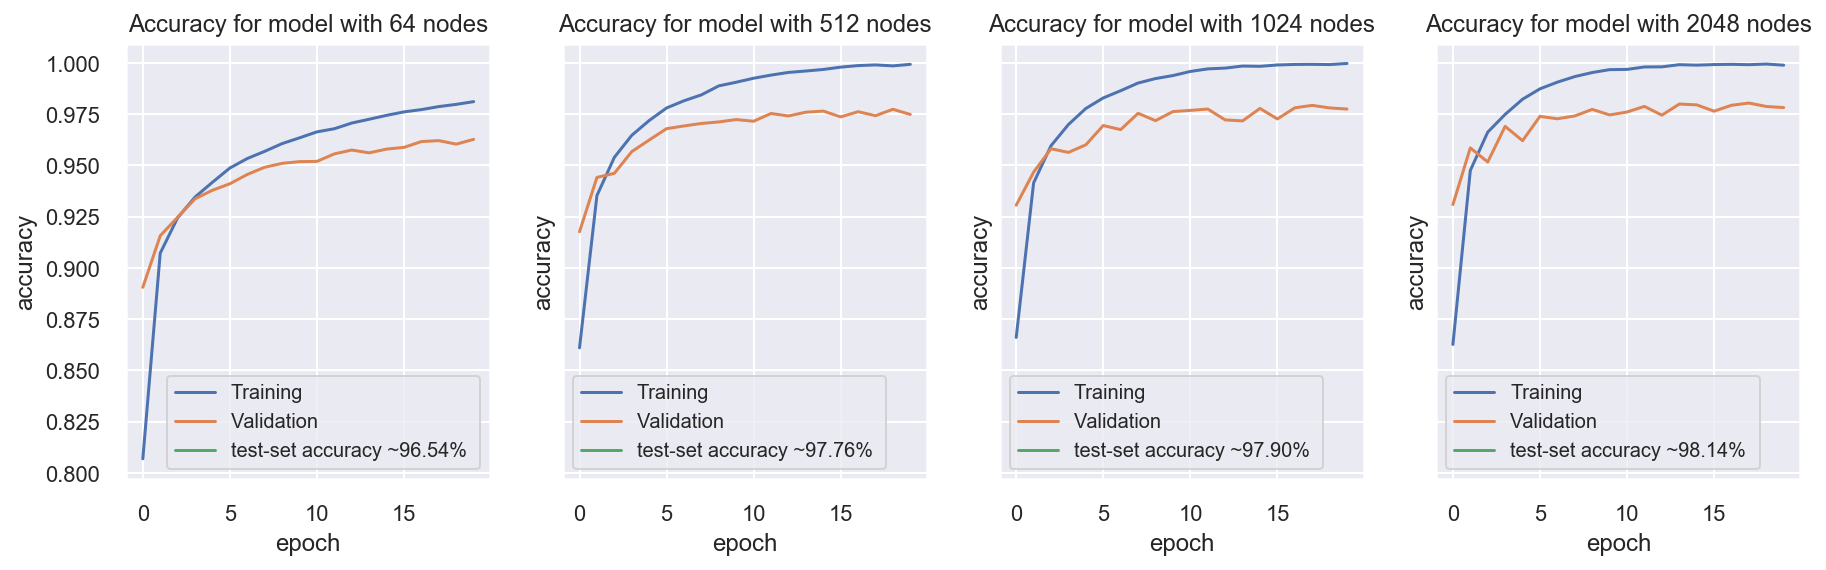

In [136]:

layer_sizes = [64, 512, 1024, 2048]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 4), sharex=True, sharey=True)

for i, layer_size in enumerate(layer_sizes):
    width_model = create_dense(layer_size, num_classes=10, image_size=784)
    history, results = evaluate(width_model, partial_images, val_images, partial_labels, val_labels, test_images, test_labels)
    # Setting subplot legends via axis
    axs[i].plot(history.history['accuracy'])
    axs[i].plot(history.history['val_accuracy'])
    axs[i].plot(np.max(history.history['accuracy'])) 
    axs[i].set_title('Accuracy for model with {} nodes'.format(layer_size))
    axs[i].legend(['Training', 'Validation', "test-set accuracy ~{:.2f}% ".format(results[1]*100)], 
                         loc="best", frameon=True, fontsize=10)
    
    axs[i].set(xlabel='epoch', ylabel='accuracy')


#### Comments

- We see from the plots above that the performance improvements appear more conspicuous, with more nodes in the hidden layer , the model, consistently has a better performance mapping imput images to labels on the test data. Above a certain threshold ($512$ nodes), it appears that  accuracy does not significantly improve. However, there's still a sign that the model overfits the training data.

- One of the most effective and most commonly used regularization techniques for neural networks is $Dropout$. In this case, we randomly keep some network weights fixed when we would normally update them so that the network doesn't rely too much on very few nodes. This is an effort to reduce overfitting by randomly removing a different subsets of neurons on each observation.

- This can be implemented in Keras by adding a Dropout layer, applied to the output of the layer right before it. 

#### Version with drop-out layers

- Here, we'll tune the $drop$-$rates$, a parameter for the $Dropout$ layer to investigate the possibility of an optimal value that benhances reference model performance significantly. 

In [137]:
def create_dense(layer_size, drop_rate, num_classes=10, image_size=784):
    from keras import models
    from keras import layers
    # Define the sequential model
    model = models.Sequential()
    # add initial layer
    model.add(layers.Dense(layer_size, activation='relu', input_shape=(image_size,)))
    model.add(layers.Dropout(drop_rate))
    # add final (output) layer
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    return model

def evaluate(model, X_train, X_val, y_train, y_val, X_test, y_test, batch_size=512, epochs=20):
    # compile model using standard parameters
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    # train and validate model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=False)   
    # evaluate model on test-set
    results  = model.evaluate(X_test, y_test, verbose=False)
    
    return [history, results]
    

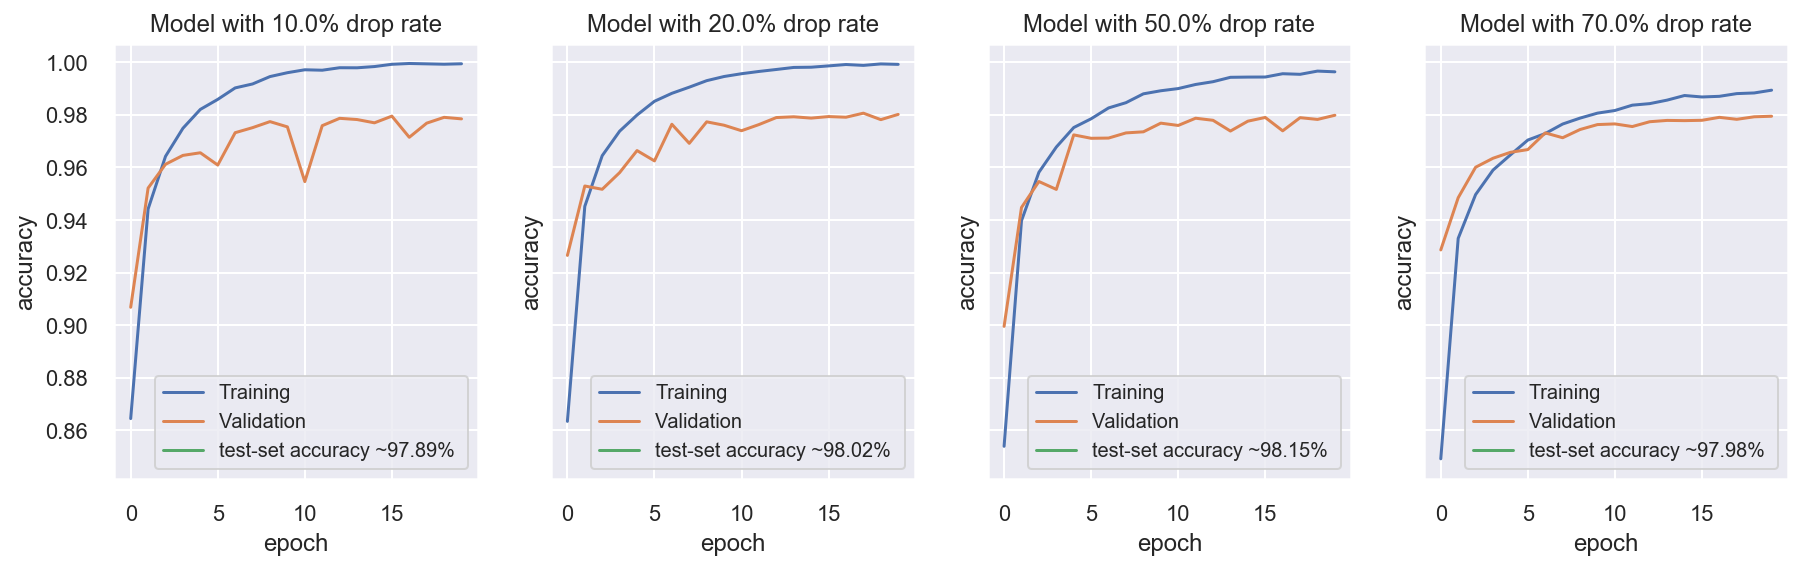

In [138]:

drop_rates = [0.1, 0.2, 0.5, 0.7]
layer_size = 2048

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 4), sharex=True, sharey=True)

for i, drop_rate in enumerate(drop_rates):
    drop_out_model = create_dense(layer_size, drop_rate, num_classes=10, image_size=784)
    history, results = evaluate(drop_out_model, partial_images, val_images, partial_labels, val_labels, test_images, test_labels)
    # Setting subplot legends via axis
    axs[i].plot(history.history['accuracy'])
    axs[i].plot(history.history['val_accuracy'])
    axs[i].plot(np.max(history.history['accuracy'])) 
    axs[i].set_title('Model with {}% drop rate'.format(drop_rate*100))
    axs[i].legend(['Training', 'Validation', "test-set accuracy ~{:.2f}% ".format(results[1]*100)], 
                         loc="best", frameon=True, fontsize=10)
    
    axs[i].set(xlabel='epoch', ylabel='accuracy')


#### Comments

- We again see that adding a dropout layer offers no significant model improvement since a litle gap still exists betwen training and validation accuracy and test-set accuracy is stil ~$98$%. 

#### Set-up Predictability

- In summary, we see that the model versions considered do not provide considerable improvements to the reference model. More so, versions with lower capacity (eg, network with $64$ nodes) likely creates information bottlenecks, resulting in an obsolute accuracy drop of ~$96$%. 

- Therefore, the reference model appears to be the optimal model for prediction. We can visually evaluate the correct and incorrect predictions to glean insight into why the model peaks at 98%. 

In [139]:
# obtain predictions on the test set
predictions = np.argmax(model.predict(test_images), axis=1)

# see which we predicted correctly and which was not. store the indices in array
correct_indices = np.nonzero(predictions == np.argmax(test_labels, axis=1))[0]
incorrect_indices = np.nonzero(predictions != np.argmax(test_labels, axis=1))[0]

print('There are {} correctly classified images'.format(len(correct_indices)))
print('There are {} incorrectly classified images'.format(len(incorrect_indices)))

There are 9742 correctly classified images
There are 258 incorrectly classified images


#### Correctly classified images

In [140]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15, 4), sharex=True, sharey=True)

for i, correct in enumerate(correct_indices[:6]):
    axs[i].imshow(test_images[correct].reshape(28,28), cmap='gray', interpolation='none')
    axs[i].set_title("Predicted: {}, Ground Truth: {}".format(predictions[correct], np.argmax(test_labels, axis=1)[correct]),
              fontsize=10)
    plt.xticks([])
    plt.yticks([])

#### Incorrectly classified images

In [141]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15, 4), sharex=True, sharey=True)

for i, incorrect in enumerate(incorrect_indices[10:16]):
    axs[i].imshow(test_images[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    axs[i].set_title("Predicted: {}, Ground Truth: {}".format(predictions[incorrect], np.argmax(test_labels, axis=1)[incorrect]),
              fontsize=10)
    plt.xticks([])
    plt.yticks([])

- We can see that the wrong predictions in some instances are even difficult for the human reader to discern, suggesting that these wrongly classified images and by extension, model accuracy, is within acceptable threshold.

- In summary, it has been justified that this network consisting of a sequence of two dense neural layers, where the first (and only hidden) layer is a $784$-way $relu$ layer and the second (and last) layer is a $10$-way $softmax$ layer is a pretty decent model for this handwritten MNIST dataset. 

## Thank you